# Training CNN-models

This notebook builds, trains and evaluates a CNN model on the data.
It compares the results to an approach with transfer learning. 

# Preamble

## Loading libraries

In [1]:
import gc
from keras import backend as K

from skimage import color, exposure, transform, io
from PIL import Image

import numpy as np
import pandas as pd
from datetime import datetime


# graphics
import seaborn as sns
import matplotlib.pyplot as plt

#import joblib   # for loading pkl file of encoder

# sklearn
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


# TF and Keras
import tensorflow as tf
import keras.optimizers
from keras.callbacks import EarlyStopping
#from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


# tweaks for GPU, could be disabled if not running on compatible GPU (but bring a lot of time if not training on GPU)
from keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')
tf.config.optimizer.set_jit(True)



2025-06-15 14:00:27.710424: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-15 14:00:27.716964: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 14:00:27.724838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 14:00:27.727157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 14:00:27.733656: I tensorflow/core/platform/cpu_feature_guar

## Initialising global variables

In [2]:
# Variables

# paths for loading pictures and encodings
OVERVIEW_CSV_PATH = './data/processed-overview.csv'
CLEAN_IMG_FOLDER='./data/processed'

# paths for saving train,val,test dataframes
TRAIN_DF = './data/train.csv'
TRAIN_MIDSAMPLED_DF = './data/train-midsamp.csv'
VAL_DF = './data/val.csv'
TEST_DF = './data/test.csv'

MODEL_PATH = './models/'


# experimental results go here
RESULT_CSV = './results.csv'    # results_200_200.csv lists the result from runs with images of size 200x200

# 
IMG_SIZE = 224       # src imgs are not square, should I just squash them into squares?

BATCH_SIZE = 32



In [3]:
# enable automatic garbage collection
gc.enable()

## Loading dataframe with picture data 

In [4]:
clean_df = pd.read_csv(OVERVIEW_CSV_PATH)

## Auxiliary functions

In [5]:
from auxiliary import *    # unfortunately relies on some of the global variables, hence do not import before loading those


# Set up dataframes, prepare datasets for feeding model

## Prepare train-test-split on dataframe

In [6]:
# create train-test-split on cleaned, but imbalanced dataset as input for upsampling version
train_df, intermed_df = train_test_split(clean_df, stratify=clean_df['category'], test_size=0.3, random_state=5)
val_df, test_df = train_test_split(intermed_df, stratify=intermed_df['category'], test_size=1/3, random_state=5)
del(intermed_df)

In [7]:
train_df.groupby('category')['name'].count()

category
butterfly    1478
cat          1168
chicken      2169
cow          1306
dog          3404
elephant     1012
horse        1836
sheep        1274
spider       3375
squirrel     1303
Name: name, dtype: int64

In [8]:
val_df.groupby('category')['name'].count()

category
butterfly    423
cat          333
chicken      619
cow          373
dog          973
elephant     289
horse        525
sheep        364
spider       964
squirrel     373
Name: name, dtype: int64

Export the split dataframes for further use.

In [9]:
train_df.to_csv(TRAIN_DF)
val_df.to_csv(VAL_DF)
test_df.to_csv(TEST_DF)

## Sampling dataframes to create three balanced training sets

I am creating three versions of the training set:

- downsampled to size of smallest category
- upsampled to size of largest category
- "midsampled" to mean size of categories

In [10]:
# downsampling to minimum size
train_downsampled_df = sample_to_n(train_df,n='min')
print('Downsampled distribution')
print(train_downsampled_df['category'].value_counts())

# upsampling to maximum size
train_upsampled_df = sample_to_n(train_df,n='max')
print('Upsampled distribution')
print(train_upsampled_df['category'].value_counts())


# sampling to mean category size

train_midsampled_df = sample_to_n(train_df,n='mean')
print('Mean-sampled distribution')
print(train_midsampled_df['category'].value_counts())

# export midsampled training dataset for reuse
train_midsampled_df.to_csv(TRAIN_MIDSAMPLED_DF)


Downsampled distribution
category
butterfly    1012
cat          1012
chicken      1012
cow          1012
dog          1012
elephant     1012
horse        1012
sheep        1012
spider       1012
squirrel     1012
Name: count, dtype: int64
Upsampled distribution
category
butterfly    3404
cat          3404
chicken      3404
cow          3404
dog          3404
elephant     3404
horse        3404
sheep        3404
spider       3404
squirrel     3404
Name: count, dtype: int64
Mean-sampled distribution
category
butterfly    1832
cat          1832
chicken      1832
cow          1832
dog          1832
elephant     1832
horse        1832
sheep        1832
spider       1832
squirrel     1832
Name: count, dtype: int64


## Preparing datasets and generators

In [11]:
# Creating datasets for feeding training data
ds_downsample_train = mk_tf_dataset(train_downsampled_df,augment=True)      # training on downsampled data
ds_upsample_train = mk_tf_dataset(train_upsampled_df,augment=True)          # training on upsampled data (to max)
ds_midsample_train = mk_tf_dataset(train_midsampled_df,augment=True)        # training on up/down-sampled data (to mean)


# creating datasets for validation and test
ds_val = mk_tf_dataset(val_df,shuffle=False)
ds_test = mk_tf_dataset(test_df,shuffle=False)

I0000 00:00:1749988829.672933   34669 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1749988829.840197   34669 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1749988829.841406   34669 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1749988829.843841   34669 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# CNN-Model baseline

## Setup

In [13]:
lr = 0.0007
specialAdam = keras.optimizers.Adam(learning_rate=lr)


downsamp_base_model = Sequential([
    # First convolutional layer with 32 filters, 3x3 kernel, ReLU activation
    # Input shape is 28x28 pixels with 1 color channel (grayscale)
    Conv2D(128, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    # Max pooling layer to reduce spatial dimensions by a factor of 3
    MaxPooling2D(3,3),
    # Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3,3), activation='relu'),
    # Another max pooling layer to reduce size further
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
downsamp_base_model.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

downsamp_base_model.summary()

/home/georg/anaconda3/envs/tensorvenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,350,314 (20.41 MB)

 Trainable params: 5,350,314 (20.41 MB)

 Non-trainable params: 0 (0.00 B)

## Fitting the model on downsampled data

Epoch 1/15


I0000 00:00:1749793171.915605  548089 service.cc:146] XLA service 0x7fc540016260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749793171.915648  548089 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-13 07:39:31.927420: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
I0000 00:00:1749793171.957243  548089 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-06-13 07:39:35.518183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


317/317 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.1435 - loss: 2.2974 - val_accuracy: 0.0875 - val_loss: 2.2757
Epoch 2/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2127 - loss: 2.1636 - val_accuracy: 0.3079 - val_loss: 1.9690
Epoch 3/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.2983 - loss: 1.9783 - val_accuracy: 0.3442 - val_loss: 1.8554
Epoch 4/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3377 - loss: 1.8668 - val_accuracy: 0.3822 - val_loss: 1.7282
Epoch 5/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.3713 - loss: 1.7813 - val_accuracy: 0.3877 - val_loss: 1.7000
Epoch 6/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4027 - loss: 1.6937 - val_accuracy: 0.4028 - val_loss: 1.6498
Epoch 7/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4178 - loss: 1.6536 - val_accuracy: 0.4303 - val_loss: 1.6203
Epoch 8/15
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.4329 - loss: 1.5995 - val_accuracy: 0.42

2025-06-13 07:41:42.963223: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Accuracy: 0.5260
Precision: 0.5575
Recall: 0.5260
F1 Score: 0.5225
              precision    recall  f1-score   support

   butterfly       0.63      0.80      0.70       211
         cat       0.37      0.41      0.39       167
     chicken       0.50      0.61      0.55       310
         cow       0.46      0.30      0.37       187
         dog       0.68      0.32      0.43       486
    elephant       0.38      0.56      0.45       145
       horse       0.51      0.60      0.55       262
       sheep       0.41      0.48      0.44       182
      spider       0.75      0.62      0.68       482
    squirrel       0.37      0.61      0.46       186

    accuracy                           0.53      2618
   macro avg       0.51      0.53      0.50      2618
weighted avg       0.56      0.53      0.52      2618



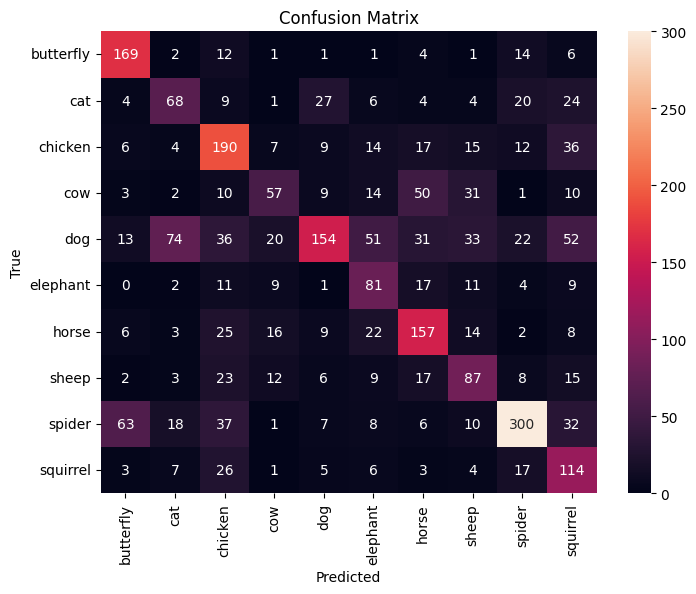

In [14]:
EPOCHS = 15

downsamp_report = train_and_report(downsamp_base_model,ds_downsample_train,ds_val,ds_test,test_df,'base_downsamp_augment+',lr,EPOCHS,BATCH_SIZE)

This result could be better, just slightly over 50% accuracy overall. Worst recall for the class dog, which is often confused with horse, cat, sheep or cow. Worst precision for classes cat and cow.

Since the accuracy still went up, more training epochs may improve the result.

## Fitting on upsampled data

In [15]:
specialAdam = keras.optimizers.Adam(learning_rate=0.0007)


upsamp_base_model = Sequential([
    # First convolutional layer with 32 filters, 3x3 kernel, ReLU activation
    # Input shape is 28x28 pixels with 1 color channel (grayscale)
    Conv2D(128, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    # Max pooling layer to reduce spatial dimensions by a factor of 3
    MaxPooling2D(3,3),
    # Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3,3), activation='relu'),
    # Another max pooling layer to reduce size further
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
upsamp_base_model.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

upsamp_base_model.summary()

/home/georg/anaconda3/envs/tensorvenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,350,314 (20.41 MB)

 Trainable params: 5,350,314 (20.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


2025-06-13 07:41:55.195151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 27240 of 34040
2025-06-13 07:42:03.449734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 48s 24ms/step - accuracy: 0.1848 - loss: 2.2280 - val_accuracy: 0.3207 - val_loss: 1.8743
Epoch 2/15


2025-06-13 07:42:42.393704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 23528 of 34040
2025-06-13 07:42:52.393431: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 32640 of 34040
2025-06-13 07:42:54.481216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - accuracy: 0.3262 - loss: 1.8738 - val_accuracy: 0.4118 - val_loss: 1.6595
Epoch 3/15


2025-06-13 07:43:25.188387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 29050 of 34040


   2/1064 ━━━━━━━━━━━━━━━━━━━━ 44s 42ms/step - accuracy: 0.3281 - loss: 1.7904904

2025-06-13 07:43:29.038724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 35s 20ms/step - accuracy: 0.3955 - loss: 1.6934 - val_accuracy: 0.4442 - val_loss: 1.5794
Epoch 4/15


2025-06-13 07:44:00.256508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 18483 of 34040
2025-06-13 07:44:09.870833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.4312 - loss: 1.6117 - val_accuracy: 0.4427 - val_loss: 1.5798
Epoch 5/15


2025-06-13 07:44:40.455079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 30814 of 34040


   7/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4386 - loss: 1.6093 

2025-06-13 07:44:42.643374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.4577 - loss: 1.5374 - val_accuracy: 0.4473 - val_loss: 1.5555
Epoch 6/15


2025-06-13 07:45:11.389956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24490 of 34040
2025-06-13 07:45:16.991401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - accuracy: 0.4771 - loss: 1.4767 - val_accuracy: 0.4945 - val_loss: 1.4407
Epoch 7/15


2025-06-13 07:45:47.978741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 23254 of 34040
2025-06-13 07:45:52.445279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 35s 19ms/step - accuracy: 0.5011 - loss: 1.4177 - val_accuracy: 0.4807 - val_loss: 1.5276
Epoch 8/15


2025-06-13 07:46:22.966370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 24730 of 34040


   5/1064 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6034 - loss: 1.1665 

2025-06-13 07:46:27.520406: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.5173 - loss: 1.3735 - val_accuracy: 0.5386 - val_loss: 1.3397
Epoch 9/15
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.5284 - loss: 1.3475 - val_accuracy: 0.5248 - val_loss: 1.3646
Epoch 10/15


2025-06-13 07:47:25.242760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 23943 of 34040


   7/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.4452 - loss: 1.3850

2025-06-13 07:47:29.239111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.5399 - loss: 1.3098 - val_accuracy: 0.5300 - val_loss: 1.3885
Epoch 11/15
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 30s 19ms/step - accuracy: 0.5550 - loss: 1.2700 - val_accuracy: 0.5378 - val_loss: 1.3401
Epoch 12/15


2025-06-13 07:48:28.553460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 31380 of 34040


   9/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.6242 - loss: 1.1255

2025-06-13 07:48:29.722866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.5703 - loss: 1.2399 - val_accuracy: 0.5659 - val_loss: 1.2770
Epoch 13/15
   7/1064 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.6117 - loss: 1.2447 

2025-06-13 07:48:59.679942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 33912 of 34040
2025-06-13 07:48:59.713854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.5775 - loss: 1.2072 - val_accuracy: 0.5210 - val_loss: 1.4696
Epoch 14/15
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.5822 - loss: 1.1970 - val_accuracy: 0.5206 - val_loss: 1.4603
Epoch 15/15


2025-06-13 07:49:54.761986: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 25300 of 34040


   7/1064 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.5619 - loss: 1.2478

2025-06-13 07:49:57.778125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 34s 19ms/step - accuracy: 0.5895 - loss: 1.1789 - val_accuracy: 0.5336 - val_loss: 1.3880
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Accuracy: 0.5668
Precision: 0.5939
Recall: 0.5668
F1 Score: 0.5645
              precision    recall  f1-score   support

   butterfly       0.65      0.82      0.73       211
         cat       0.40      0.49      0.44       167
     chicken       0.56      0.67      0.61       310
         cow       0.57      0.35      0.44       187
         dog       0.66      0.37      0.47       486
    elephant       0.47      0.67      0.55       145
       horse       0.53      0.60      0.56       262
       sheep       0.37      0.63      0.46       182
      spider       0.79      0.67      0.72       482
    squirrel       0.51      0.45      0.48       186

    accuracy                           0.57      2618
   macro avg       0.55      0.57      0.55      2618
weighted avg       0.59      0.57      0.56      2618



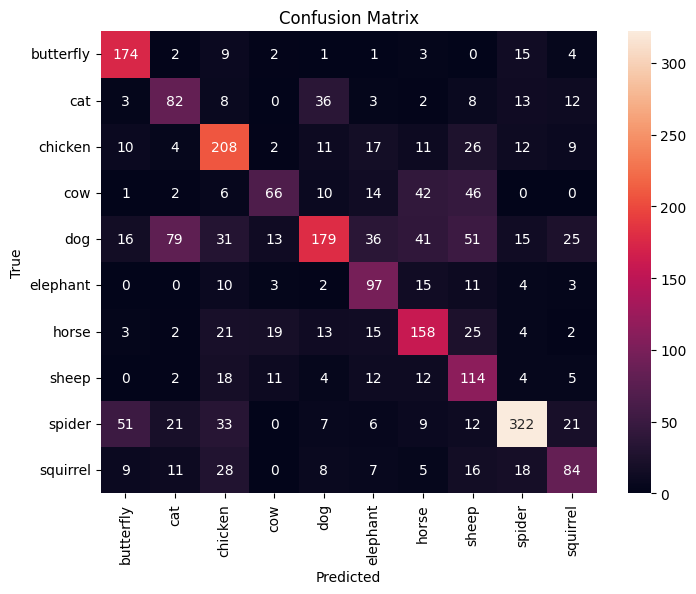

In [16]:
EPOCHS = 15

upsamp_report = train_and_report(upsamp_base_model,ds_upsample_train,ds_val, ds_test,test_df,'base_upsamp_augment+',lr,EPOCHS,BATCH_SIZE)

## Comparing to mean-sampling

In [17]:
specialAdam = keras.optimizers.Adam(learning_rate=0.0007)


midsamp_base_model = Sequential([
    # First convolutional layer with 32 filters, 3x3 kernel, ReLU activation
    # Input shape is 28x28 pixels with 1 color channel (grayscale)
    Conv2D(128, (3,3), activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
    # Max pooling layer to reduce spatial dimensions by a factor of 3
    MaxPooling2D(3,3),
    # Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3,3), activation='relu'),
    # Another max pooling layer to reduce size further
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
midsamp_base_model.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

midsamp_base_model.summary()

/home/georg/anaconda3/envs/tensorvenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,350,314 (20.41 MB)

 Trainable params: 5,350,314 (20.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.1352 - loss: 2.3276 - val_accuracy: 0.2382 - val_loss: 2.0920
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.2778 - loss: 2.0183 - val_accuracy: 0.3457 - val_loss: 1.8265
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.3588 - loss: 1.8127 - val_accuracy: 0.3793 - val_loss: 1.7150
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3949 - loss: 1.7024 - val_accuracy: 0.4100 - val_loss: 1.6798
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4290 - loss: 1.6284 - val_accuracy: 0.4521 - val_loss: 1.5294
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4530 - loss: 1.5624 - val_accuracy: 0.4708 - val_loss: 1.4815
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.4831 - loss: 1.4804 - val_accuracy: 0.4706 - val_loss: 1.5165
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5052 - loss: 1.4325 - 

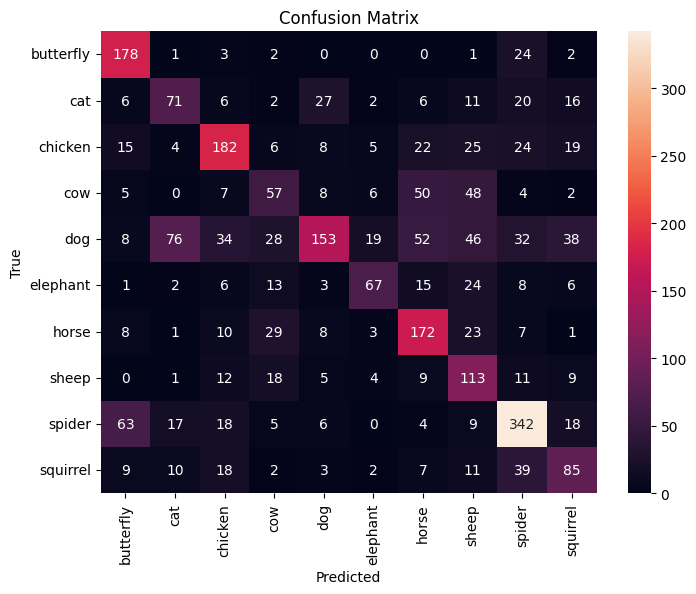

In [18]:
EPOCHS = 15

midsamp_report = train_and_report(midsamp_base_model,ds_midsample_train,ds_val,ds_test,test_df,'base_meansamp_augment+',lr,EPOCHS,BATCH_SIZE)

In [19]:
# print_side_by_side(downsamp_report, upsamp_report, midsamp_report)

I would actually prefer to use the medium-sized meansampled training set, but I am a bit concerned about the low recall in the categories cow and squirrel.

Check if 20 additional epochs improve it.

In [20]:
# EPOCHS = 20

# from keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# # Train model using data augmentation
# midsamp_base_hist = midsamp_base_model.fit(
#     ds_midsample_train,
#     epochs=EPOCHS,
#     validation_data=ds_val,
#     verbose=1,
#     callbacks=early_stop
# )

# train_acc = midsamp_base_hist.history['accuracy'][-1]
# val_acc = midsamp_base_hist.history['val_accuracy'][-1]
# midsamp_report = print_evaluation(midsamp_base_model,ds_test,test_df,train_acc,val_acc,'base_meansamp',lr,EPOCHS,BATCH_SIZE)

In [21]:
# print_side_by_side(downsamp_report, upsamp_report, midsamp_report)

Training stopped after 6 more epochs. In terms of overall accuracy, the larger datasets offer no significant improvement, and actually perform slightly worse.

I have expanded the augmentation operations, the new results will be logged with 'augment+' and a higher number of 15 epochs. Afterwards, I am going to decide on one dataset for some further model tweaking below.

In [22]:
print_side_by_side(downsamp_report, upsamp_report, midsamp_report)

              precision    recall  f1-score   support                  precision    recall  f1-score   support                  precision    recall  f1-score   support
                                                                                                  
   butterfly       0.63      0.80      0.70       211       butterfly       0.65      0.82      0.73       211       butterfly       0.61      0.84      0.71       211
         cat       0.37      0.41      0.39       167             cat       0.40      0.49      0.44       167             cat       0.39      0.43      0.41       167
     chicken       0.50      0.61      0.55       310         chicken       0.56      0.67      0.61       310         chicken       0.61      0.59      0.60       310
         cow       0.46      0.30      0.37       187             cow       0.57      0.35      0.44       187             cow       0.35      0.30      0.33       187
         dog       0.68      0.32      0.43       486        

This looks better, the mean-sampled training set actually gives the best accuracy now. I'll continue tweaking the model using that dataset exclusively now.

In [23]:
del(train_downsampled_df,train_upsampled_df,ds_downsample_train,ds_upsample_train,upsamp_base_model,downsamp_base_model)
gc.collect()

46674

# Tweaking the CNN-model using the mid-sampled training set

## conv4dense2

In [24]:
lr = 0.0007
EPOCHS = 25

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4dense2 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    # First convolutional layer with 32 filters, 3x3 kernel, ReLU activation
    # Input shape is 28x28 pixels with 1 color channel (grayscale)
    Conv2D(128, (3,3), activation='relu'),
    # Max pooling layer to reduce spatial dimensions by a factor of 3
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Second convolutional layer with 64 filters, 3x3 kernel, ReLU activation
    Conv2D(32, (3,3), activation='relu'),
    # Another max pooling layer to reduce size further
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4dense2.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4dense2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 9, 9, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,890 (792.54 KB)

 Trainable params: 202,890 (792.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.1276 - loss: 2.2744 - val_accuracy: 0.2309 - val_loss: 2.0978
Epoch 2/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2214 - loss: 2.1053 - val_accuracy: 0.3090 - val_loss: 1.9378
Epoch 3/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2727 - loss: 1.9830 - val_accuracy: 0.3585 - val_loss: 1.7672
Epoch 4/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3302 - loss: 1.8472 - val_accuracy: 0.3852 - val_loss: 1.7100
Epoch 5/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3977 - loss: 1.6934 - val_accuracy: 0.4385 - val_loss: 1.5464
Epoch 6/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4289 - loss: 1.6310 - val_accuracy: 0.4521 - val_loss: 1.4948
Epoch 7/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4555 - loss: 1.5486 - val_accuracy: 0.4983 - val_loss: 1.4070
Epoch 8/25
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4831 - loss: 1.4914 - 

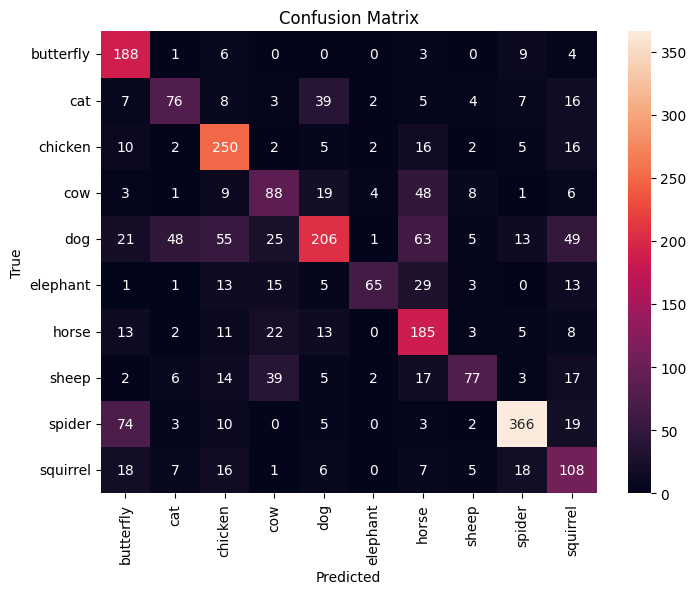

In [25]:

conv4dense2_report = train_and_report(conv4dense2,ds_midsample_train,ds_val,ds_test,test_df,'conv4dense2',lr,EPOCHS,BATCH_SIZE)

In [26]:
print_side_by_side(midsamp_report,conv4dense2_report)

              precision    recall  f1-score   support                  precision    recall  f1-score   support
                                                                
   butterfly       0.61      0.84      0.71       211       butterfly       0.56      0.89      0.69       211
         cat       0.39      0.43      0.41       167             cat       0.52      0.46      0.48       167
     chicken       0.61      0.59      0.60       310         chicken       0.64      0.81      0.71       310
         cow       0.35      0.30      0.33       187             cow       0.45      0.47      0.46       187
         dog       0.69      0.31      0.43       486             dog       0.68      0.42      0.52       486
    elephant       0.62      0.46      0.53       145        elephant       0.86      0.45      0.59       145
       horse       0.51      0.66      0.57       262           horse       0.49      0.71      0.58       262
       sheep       0.36      0.62      0.46    

This took a long time training for a rather marginal improvement. Let's try simplifying the model a bit. 

In [27]:
# free up space
del(conv4dense2)
gc.collect()


18114

## conv4small_dense1 (decent-ish results, comparatively fast)

In [28]:
lr = 0.0007
EPOCHS = 30

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4small_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4small_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4small_dense1.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,554 (1.02 MB)

 Trainable params: 268,554 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.1497 - loss: 2.2414 - val_accuracy: 0.2242 - val_loss: 2.1280
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2962 - loss: 1.9282 - val_accuracy: 0.3780 - val_loss: 1.7278
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3770 - loss: 1.7408 - val_accuracy: 0.4272 - val_loss: 1.6126
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4305 - loss: 1.6175 - val_accuracy: 0.4026 - val_loss: 1.7520
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4671 - loss: 1.5194 - val_accuracy: 0.4977 - val_loss: 1.4153
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4986 - loss: 1.4293 - val_accuracy: 0.4864 - val_loss: 1.5092
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5200 - loss: 1.3702 - val_accuracy: 0.4924 - val_loss: 1.4572
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5472 - loss: 1.3082 - 

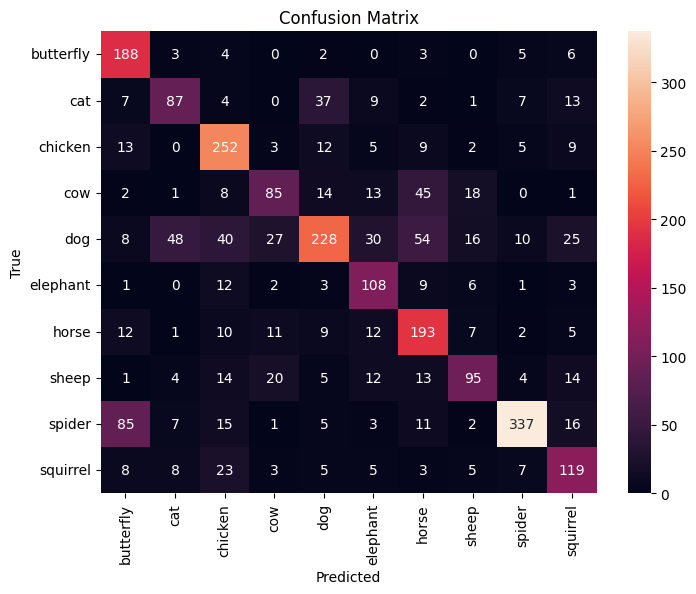

In [29]:

conv4small_dense1_report = train_and_report(conv4small_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv4small_dense1',lr,EPOCHS,BATCH_SIZE)

Decent improvement! Let's see if we can boost this further with some tweaking to the model.

## Adding a layer (conv5_dense1)

Let's add another layer.

In [30]:
lr = 0.0007
EPOCHS = 30

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv5_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv5_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv5_dense1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 5, 5, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,322 (466.10 KB)

 Trainable params: 119,322 (466.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.1371 - loss: 2.2513 - val_accuracy: 0.2150 - val_loss: 2.0861
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.2336 - loss: 2.0842 - val_accuracy: 0.2836 - val_loss: 1.9749
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.3069 - loss: 1.9356 - val_accuracy: 0.3325 - val_loss: 1.8033
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.3552 - loss: 1.8022 - val_accuracy: 0.4236 - val_loss: 1.6096
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.3940 - loss: 1.7094 - val_accuracy: 0.4341 - val_loss: 1.6347
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4096 - loss: 1.6619 - val_accuracy: 0.4158 - val_loss: 1.6581
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4416 - loss: 1.5897 - val_accuracy: 0.4278 - val_loss: 1.5834
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4640 - loss: 1.5245 - 

2025-06-13 08:10:55.307253: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 12 bytes spill stores, 12 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy: 0.5859
Precision: 0.6024
Recall: 0.5859
F1 Score: 0.5785
              precision    recall  f1-score   support

   butterfly       0.68      0.85      0.75       211
         cat       0.51      0.38      0.43       167
     chicken       0.69      0.68      0.69       310
         cow       0.43      0.30      0.35       187
         dog       0.66      0.37      0.47       486
    elephant       0.48      0.70      0.57       145
       horse       0.44      0.71      0.54       262
       sheep       0.59      0.47      0.52       182
      spider       0.76      0.76      0.76       482
    squirrel       0.41      0.57      0.48       186

    accuracy                           0.59      2618
   macro avg       0.56      0.58      0.56      2618
weighted avg       0.60      0.59      0.58      2618



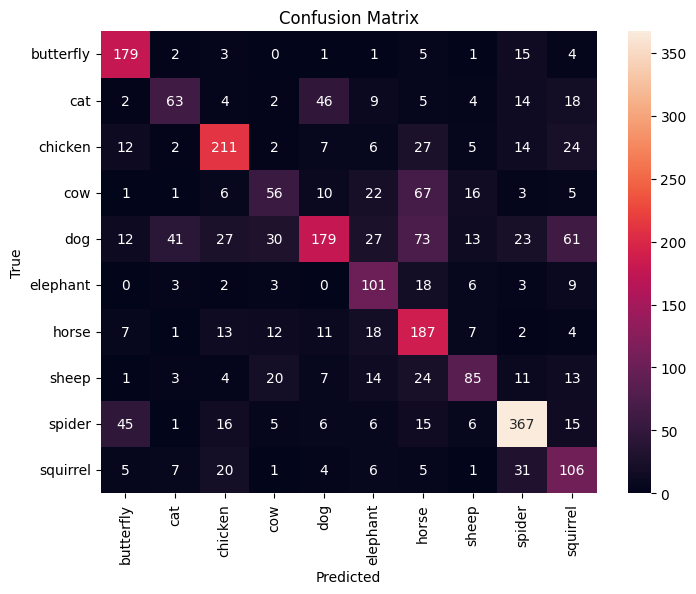

In [31]:

conv5_dense1_report = train_and_report(conv5_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv5_dense1',lr,EPOCHS,BATCH_SIZE)

No good result. Let's try with smaller convolutional layers if we want 5

In [32]:
del(conv5_dense1)
gc.collect()

29449

## conv5small_dense1

In [33]:
lr = 0.0007
EPOCHS = 30

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv5small_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv5small_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv5small_dense1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 10, 10, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        51,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,346 (407.60 KB)

 Trainable params: 104,346 (407.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.1349 - loss: 2.2530 - val_accuracy: 0.1713 - val_loss: 2.1394
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2672 - loss: 2.0122 - val_accuracy: 0.3533 - val_loss: 1.7988
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3487 - loss: 1.8140 - val_accuracy: 0.4110 - val_loss: 1.6683
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4006 - loss: 1.6951 - val_accuracy: 0.4272 - val_loss: 1.6021
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4500 - loss: 1.5624 - val_accuracy: 0.4544 - val_loss: 1.5558
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4803 - loss: 1.4859 - val_accuracy: 0.4859 - val_loss: 1.4996
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5110 - loss: 1.4015 - val_accuracy: 0.5130 - val_loss: 1.3936
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.5358 - loss: 1.3267 - 

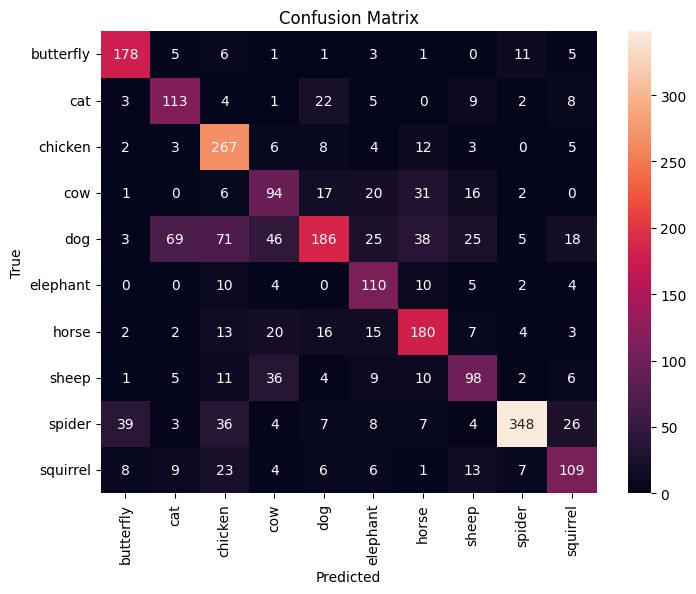

In [34]:

conv5small_dense1_report = train_and_report(conv5small_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv5small_dense1',lr,EPOCHS,BATCH_SIZE)

Worse result than conv4small_dense1 for considerably longer training time. Let's go back to that basis. 

In [35]:
del(conv5small_dense1)
gc.collect()

18045

## Return to 4 conv-layers (conv4small_dense2_lowlr)

In [36]:
lr = 0.0005
EPOCHS = 30

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4small_dense2_lowlr = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4small_dense2_lowlr.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4small_dense2_lowlr.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 72, 72, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,722 (1.04 MB)

 Trainable params: 271,722 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1314 - loss: 2.2725 - val_accuracy: 0.2026 - val_loss: 2.1230
Epoch 2/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2161 - loss: 2.1227 - val_accuracy: 0.2909 - val_loss: 1.9234
Epoch 3/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2831 - loss: 1.9630 - val_accuracy: 0.3505 - val_loss: 1.8192
Epoch 4/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3346 - loss: 1.8348 - val_accuracy: 0.4095 - val_loss: 1.6696
Epoch 5/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3831 - loss: 1.7189 - val_accuracy: 0.4587 - val_loss: 1.5567
Epoch 6/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4330 - loss: 1.6039 - val_accuracy: 0.4834 - val_loss: 1.4463
Epoch 7/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.4597 - loss: 1.5297 - val_accuracy: 0.5321 - val_loss: 1.3606
Epoch 8/30
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4889 - loss: 1.4568 - 

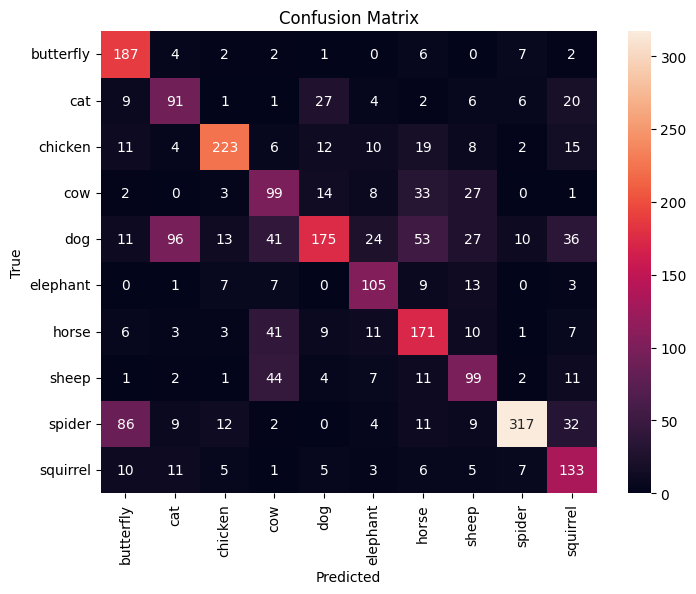

In [37]:

conv4small_dense2_lowlr_report = train_and_report(conv4small_dense2_lowlr,ds_midsample_train,ds_val,ds_test,test_df,'conv4small_dense2_lowlr',lr,EPOCHS,BATCH_SIZE)

Performs slightly worse than conv4small_dense1 with the slightly higher learning rate.

In [38]:
del(conv4small_dense2_lowlr)
gc.collect()

18006

## conv4lesspoll_dense1

Use that as baseline, but reduce the polling to keep more data accessible (monitor overfitting). Keep learning rate at slightly lower level, increase epochs by 5.

In [39]:
lr = 0.0005
EPOCHS = 35

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4lesspoll_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4lesspoll_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4lesspoll_dense1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 657,674 (2.51 MB)

 Trainable params: 657,674 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.1595 - loss: 2.2323 - val_accuracy: 0.2372 - val_loss: 2.0491
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3015 - loss: 1.9463 - val_accuracy: 0.3950 - val_loss: 1.6865
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.3758 - loss: 1.7431 - val_accuracy: 0.4536 - val_loss: 1.5157
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4389 - loss: 1.5915 - val_accuracy: 0.4708 - val_loss: 1.4924
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.4792 - loss: 1.4726 - val_accuracy: 0.5191 - val_loss: 1.3752
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5121 - loss: 1.3816 - val_accuracy: 0.5302 - val_loss: 1.3715
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5398 - loss: 1.3212 - val_accuracy: 0.5491 - val_loss: 1.3091
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.5585 - loss: 1.2482 - 

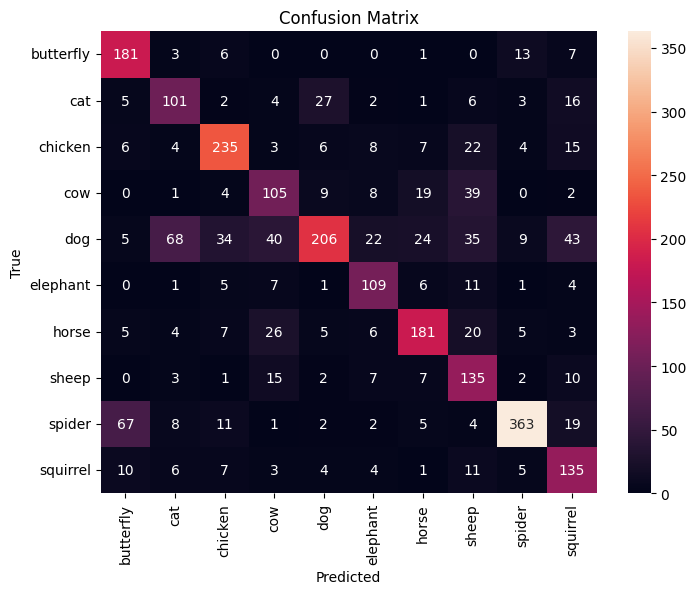

In [40]:
conv4lesspoll_dense1_report = train_and_report(conv4lesspoll_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv4lesspoll_dense1',lr,EPOCHS,BATCH_SIZE)

This led to a slight improvement, but at the cost of pretty long training time. Slight chance that more training epochs could lead to further improvement, but the improvement rate in the last epochs was already almost plateauing.

## Intermediate result overview

Quick overview of results so far:

In [41]:
pd.read_csv(RESULT_CSV).sort_values(by='accuracy',ascending=False)

,time,model_id,learning_rate,epochs,batchsize,acc_train,acc_val,accuracy,precision,recall,f1_score
8,2025-06-13 08:28:02,conv4lesspoll_dense1,0.0005,35,32,0.740393,0.598930,0.668831,0.700329,0.668831,0.668548
4,2025-06-13 08:05:14,conv4small_dense1,0.0007,30,32,0.687882,0.620321,0.646295,0.666348,0.646295,0.643038
6,2025-06-13 08:16:19,conv5small_dense1,0.0007,30,32,0.677566,0.632926,0.642857,0.665212,0.642857,0.638667
3,2025-06-13 08:00:23,conv4dense2,0.0007,25,32,0.647926,0.587471,0.614591,0.645402,0.614591,0.610750
7,2025-06-13 08:20:52,conv4small_dense2_lowlr,0.0005,30,32,0.648144,0.583270,0.611154,0.653470,0.611154,0.611810
5,2025-06-13 08:10:55,conv5_dense1,0.0007,30,32,0.599782,0.558251,0.585943,0.602430,0.585943,0.578486
1,2025-06-13 07:50:22,base_upsamp_augment+,0.0007,15,32,0.591745,0.533613,0.566845,0.593870,0.566845,0.564503
2,2025-06-13 07:54:10,base_meansamp_augment+,0.0007,15,32,0.581332,0.508594,0.542399,0.564897,0.542399,0.534725
0,2025-06-13 07:41:44,base_downsamp_augment+,0.0007,15,32,0.510178,0.490833,0.525974,0.557517,0.525974,0.522508


## conv3_dense2

In [42]:
lr = 0.0005
EPOCHS = 35

conv3_dense2 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])

specialAdam = keras.optimizers.Adam(learning_rate=lr)
conv3_dense2.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv3_dense2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 72, 72, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 34, 34, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,183,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,235,834 (4.71 MB)

 Trainable params: 1,235,834 (4.71 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.1337 - loss: 2.2689 - val_accuracy: 0.2248 - val_loss: 2.0840
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2087 - loss: 2.1304 - val_accuracy: 0.2779 - val_loss: 1.9404
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.2641 - loss: 2.0191 - val_accuracy: 0.2922 - val_loss: 1.9324
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3068 - loss: 1.9056 - val_accuracy: 0.3638 - val_loss: 1.6914
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3385 - loss: 1.8265 - val_accuracy: 0.3829 - val_loss: 1.6512
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3695 - loss: 1.7580 - val_accuracy: 0.4085 - val_loss: 1.6244
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.3934 - loss: 1.6919 - val_accuracy: 0.4555 - val_loss: 1.5444
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.4247 - loss: 1.6385 - 

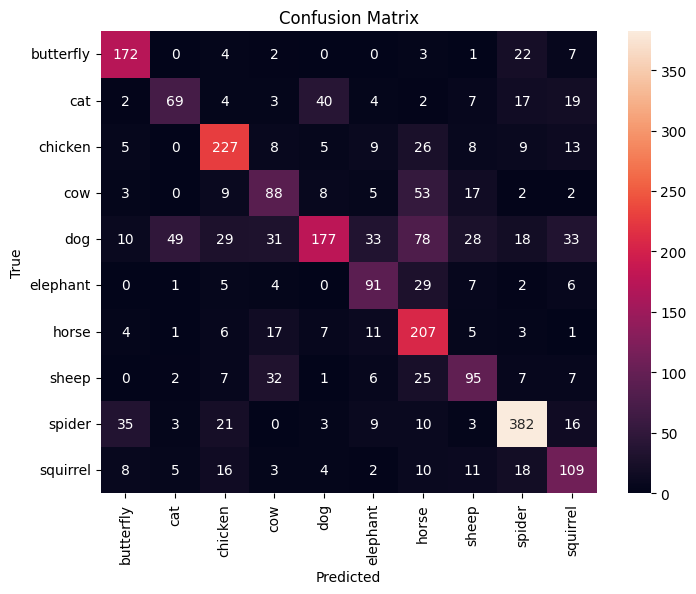

In [43]:

conv3_dense2_report = train_and_report(conv3_dense2,ds_midsample_train,ds_val,ds_test,test_df,'conv3_dense2',lr,EPOCHS,BATCH_SIZE)

Underwhelming result. Might be because of the extra dense layer, so let's remove that again and see how three convolutional layers perform.

In [44]:
del(conv3_dense2)
gc.collect()

28965

## conv3dense1

In [45]:
lr = 0.0005
EPOCHS = 35

conv3_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])

specialAdam = keras.optimizers.Adam(learning_rate=lr)
conv3_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv3_dense1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 222, 222, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 74, 74, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 72, 72, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 34, 34, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 9248)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │     1,183,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,002 (4.89 MB)

 Trainable params: 1,281,002 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.1797 - loss: 2.2007 - val_accuracy: 0.3201 - val_loss: 1.8475
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.3286 - loss: 1.8707 - val_accuracy: 0.4316 - val_loss: 1.6104
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.3948 - loss: 1.7121 - val_accuracy: 0.4433 - val_loss: 1.5954
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4471 - loss: 1.5792 - val_accuracy: 0.4750 - val_loss: 1.4805
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4698 - loss: 1.5112 - val_accuracy: 0.4851 - val_loss: 1.4841
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.4928 - loss: 1.4524 - val_accuracy: 0.5399 - val_loss: 1.3009
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5318 - loss: 1.3449 - val_accuracy: 0.5413 - val_loss: 1.3521
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.5465 - loss: 1.2991 - 

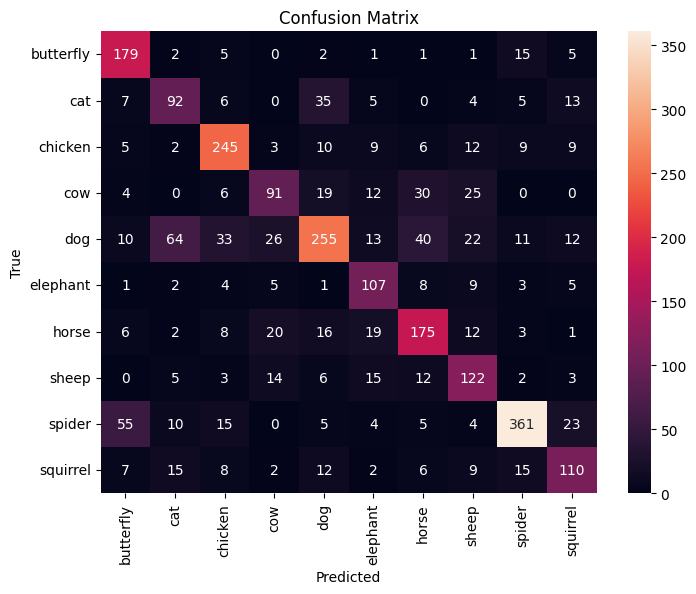

In [46]:

conv3_dense1_report = train_and_report(conv3_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv3_dense1',lr,EPOCHS,BATCH_SIZE)

Better than expected, but still worse than conv4small_dense1.

In [47]:
del(conv3_dense1)
gc.collect()

17055

## conv3invert_dense1

In [48]:
lr = 0.0005
EPOCHS = 35

conv3invert_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])

specialAdam = keras.optimizers.Adam(learning_rate=lr)
conv3invert_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv3invert_dense1.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,642 (18.42 MB)

 Trainable params: 4,829,642 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1792 - loss: 2.2164

2025-06-13 08:41:45.727811: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_84', 8 bytes spill stores, 8 bytes spill loads

2025-06-13 08:41:47.432102: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_84', 12 bytes spill stores, 12 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.1793 - loss: 2.2162 - val_accuracy: 0.3277 - val_loss: 1.8540
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.3317 - loss: 1.8600 - val_accuracy: 0.4232 - val_loss: 1.6187
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4206 - loss: 1.6537 - val_accuracy: 0.5124 - val_loss: 1.4174
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4625 - loss: 1.5315 - val_accuracy: 0.5304 - val_loss: 1.3767
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5018 - loss: 1.4350 - val_accuracy: 0.5374 - val_loss: 1.3420
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5359 - loss: 1.3479 - val_accuracy: 0.5422 - val_loss: 1.3019
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5510 - loss: 1.2917 - val_accuracy: 0.5577 - val_loss: 1.2680
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5775 - loss: 1.2190 - val_accuracy: 0.53

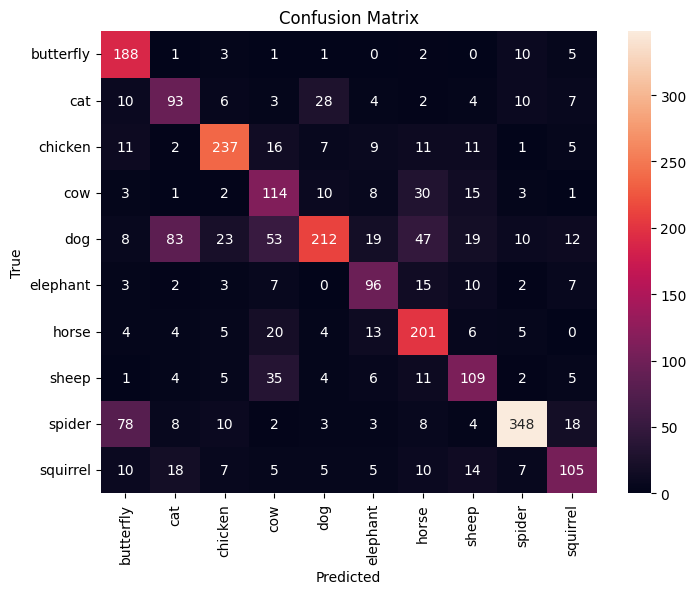

In [49]:

conv3invert_dense1_report = train_and_report(conv3invert_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv3invert_dense1',lr,EPOCHS,BATCH_SIZE)

In [50]:
del(conv3invert_dense1)
gc.collect()

16948

Good improvement, current best-performing model! Let's test if the previous best performing model can also be tuned by inverting the size of the convolutional filters.

## conv4lesspollinv_dense1

In [51]:
lr = 0.0005
EPOCHS = 35

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4lesspollinv_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4lesspollinv_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4lesspollinv_dense1.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_41 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,241,578 (4.74 MB)

 Trainable params: 1,241,578 (4.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1650 - loss: 2.2133 - val_accuracy: 0.3096 - val_loss: 1.9056
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3125 - loss: 1.9123 - val_accuracy: 0.4196 - val_loss: 1.6872
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3959 - loss: 1.6995 - val_accuracy: 0.4496 - val_loss: 1.5656
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4570 - loss: 1.5396 - val_accuracy: 0.4679 - val_loss: 1.5590
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4974 - loss: 1.4228 - val_accuracy: 0.4819 - val_loss: 1.5201
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5463 - loss: 1.3232 - val_accuracy: 0.5038 - val_loss: 1.4223
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5751 - loss: 1.2297 - val_accuracy: 0.5863 - val_loss: 1.2169
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5856 - loss: 1.1847 - val_accuracy: 

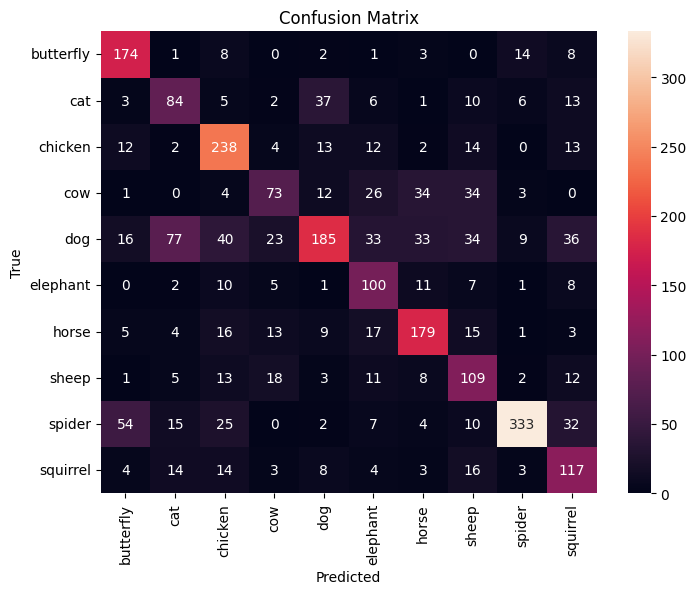

In [52]:

conv4lesspollinv_dense1_report = train_and_report(conv4lesspollinv_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv4lesspollinv_dense1',lr,EPOCHS,BATCH_SIZE)

In [53]:
print_side_by_side(conv4lesspoll_dense1_report,conv4lesspollinv_dense1_report,conv3invert_dense1_report)

              precision    recall  f1-score   support                  precision    recall  f1-score   support                  precision    recall  f1-score   support
                                                                                                  
   butterfly       0.65      0.86      0.74       211       butterfly       0.64      0.82      0.72       211       butterfly       0.59      0.89      0.71       211
         cat       0.51      0.60      0.55       167             cat       0.41      0.50      0.45       167             cat       0.43      0.56      0.49       167
     chicken       0.75      0.76      0.76       310         chicken       0.64      0.77      0.70       310         chicken       0.79      0.76      0.78       310
         cow       0.51      0.56      0.54       187             cow       0.52      0.39      0.45       187             cow       0.45      0.61      0.51       187
         dog       0.79      0.42      0.55       486        

Slightly worse actually, but I did not homogeneously increase filter size. Let's try that, too.

In [54]:
del(conv4lesspollinv_dense1)
gc.collect()

17496

## conv4invto128_dense1

In [55]:
lr = 0.0005
EPOCHS = 35

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4invto128_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4invto128_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4invto128_dense1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_45 (Conv2D)              │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,458,154 (9.38 MB)

 Trainable params: 2,458,154 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.1610 - loss: 2.2378 - val_accuracy: 0.2924 - val_loss: 1.8840
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3237 - loss: 1.8779 - val_accuracy: 0.4458 - val_loss: 1.5770
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4062 - loss: 1.6729 - val_accuracy: 0.4700 - val_loss: 1.5330
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4788 - loss: 1.5019 - val_accuracy: 0.5271 - val_loss: 1.3864
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5244 - loss: 1.3714 - val_accuracy: 0.5775 - val_loss: 1.2411
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5531 - loss: 1.2791 - val_accuracy: 0.5598 - val_loss: 1.2915
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5735 - loss: 1.2280 - val_accuracy: 0.5794 - val_loss: 1.2168
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6016 - loss: 1.1585 - val_accuracy: 

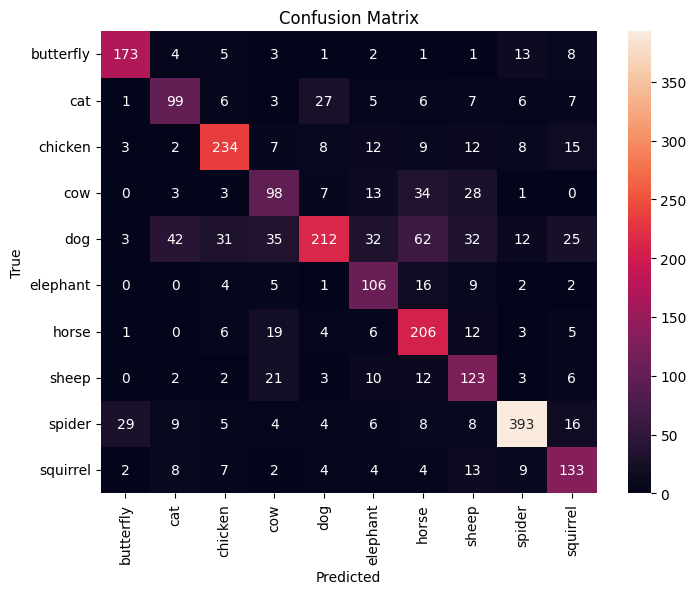

In [56]:

conv4invto128_dense1_report = train_and_report(conv4invto128_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv4invto128_dense1',lr,EPOCHS,BATCH_SIZE)

Slightly less accuracy. How about trying another 5 level model starting at 8 convolutional filters?

In [57]:
del(conv4invto128_dense1)
gc.collect()

17602

## conv5invto128_dense1

In [58]:
lr = 0.0005
EPOCHS = 35

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv5invto128_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(8, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv5invto128_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv5invto128_dense1.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_52 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 509,402 (1.94 MB)

 Trainable params: 509,402 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1514 - loss: 2.2290

2025-06-13 08:52:08.278089: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_120', 8 bytes spill stores, 8 bytes spill loads

2025-06-13 08:52:09.848149: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_120', 12 bytes spill stores, 12 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1515 - loss: 2.2288 - val_accuracy: 0.2194 - val_loss: 2.0639
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2951 - loss: 1.9556 - val_accuracy: 0.3581 - val_loss: 1.7801
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3821 - loss: 1.7277 - val_accuracy: 0.4318 - val_loss: 1.5779
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4387 - loss: 1.5917 - val_accuracy: 0.4670 - val_loss: 1.4914
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4702 - loss: 1.4939 - val_accuracy: 0.4845 - val_loss: 1.4772
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5099 - loss: 1.3942 - val_accuracy: 0.5317 - val_loss: 1.3452
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5349 - loss: 1.3321 - val_accuracy: 0.5388 - val_loss: 1.3240
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.5642 - loss: 1.2619 - val_accuracy: 0.5334 - va

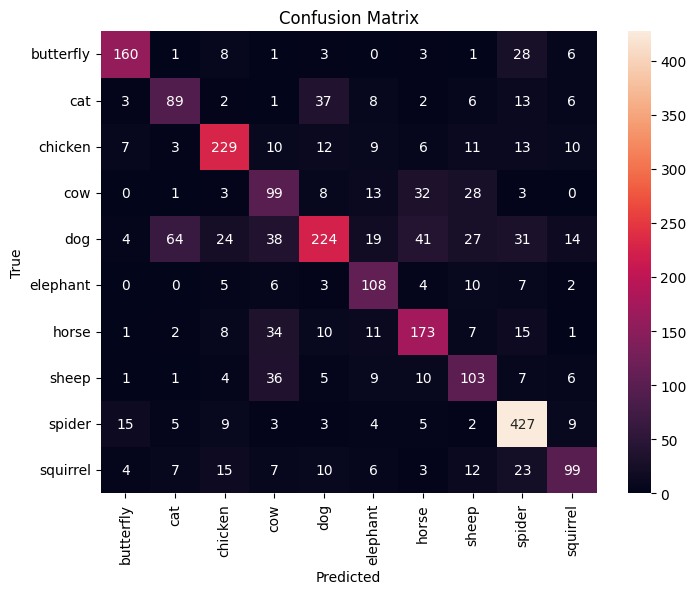

In [59]:
# and let's be a bit more patient
PATIENCE = 9
conv5invto128_dense1_report = train_and_report(conv5invto128_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv5invto128_dense1',lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE)

Actually rather good result. There might be room for improvement with more training? (Hm, actually the result was better on previous runs with the smaller picture size.)

# Longer training (80 epochs)

## conv5invto128_dense1 (extra training)

Epoch 1/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6694 - loss: 0.9566 - val_accuracy: 0.6190 - val_loss: 1.1047
Epoch 2/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6820 - loss: 0.9314 - val_accuracy: 0.6215 - val_loss: 1.1240
Epoch 3/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6824 - loss: 0.9370 - val_accuracy: 0.6261 - val_loss: 1.0788
Epoch 4/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6834 - loss: 0.9182 - val_accuracy: 0.6320 - val_loss: 1.0716
Epoch 5/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6923 - loss: 0.8858 - val_accuracy: 0.6507 - val_loss: 1.0328
Epoch 6/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.6940 - loss: 0.8841 - val_accuracy: 0.6293 - val_loss: 1.1006
Epoch 7/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7043 - loss: 0.8523 - val_accuracy: 0.6467 - val_loss: 1.0484
Epoch 8/35
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7139 - loss: 0.8289 - val_accuracy: 0.

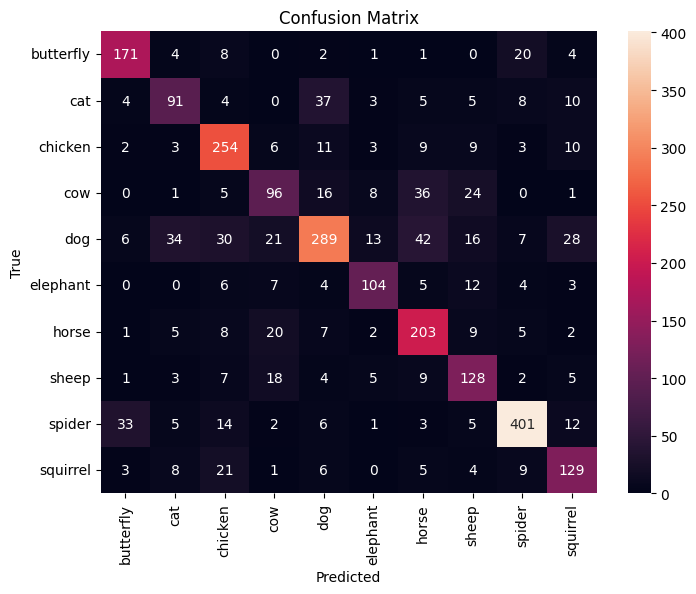

In [ ]:
# and let's be a bit more patient and train for 35 more epochs to a total of 70
EPOCHS = 35
PATIENCE = 10

conv5invto128_dense1_report = train_and_report(conv5invto128_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv5invto128_dense1_35extraepochs',lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE)

Great, in this run this model actually crossed the threshold of .7 test accuracy. Let's save it for posterity.

In [ ]:
# commenting out to avoid accidental overwriting on future runs of the notebook
# conv5invto128_dense1.save(MODEL_PATH + 'conv5invto128_dense1.keras')

## Intermission - taking stock

In [64]:
pd.read_csv(RESULT_CSV).sort_values(by='accuracy',ascending=False)

,time,model_id,learning_rate,epochs,batchsize,acc_train,acc_val,accuracy,precision,recall,f1_score
15,2025-06-13 09:00:38,conv5invto128_dense1_35extraepochs,0.0005,70,32,0.815284,0.688885,0.712758,0.717621,0.712758,0.711639
13,2025-06-13 08:51:53,conv4invto128_dense1,0.0005,35,32,0.787009,0.682009,0.678762,0.702113,0.678762,0.677501
8,2025-06-13 08:28:02,conv4lesspoll_dense1,0.0005,35,32,0.740393,0.598930,0.668831,0.700329,0.668831,0.668548
10,2025-06-13 08:41:31,conv3_dense1,0.0005,35,32,0.709116,0.622995,0.663484,0.673583,0.663484,0.662847
14,2025-06-13 08:55:29,conv5invto128_dense1,0.0005,35,32,0.723799,0.639992,0.653552,0.662628,0.653552,0.650392
11,2025-06-13 08:44:47,conv3invert_dense1,0.0005,35,32,0.716758,0.644576,0.650497,0.682056,0.650497,0.651003
4,2025-06-13 08:05:14,conv4small_dense1,0.0007,30,32,0.687882,0.620321,0.646295,0.666348,0.646295,0.643038
6,2025-06-13 08:16:19,conv5small_dense1,0.0007,30,32,0.677566,0.632926,0.642857,0.665212,0.642857,0.638667
9,2025-06-13 08:35:05,conv3_dense2,0.0005,35,32,0.613537,0.602941,0.617647,0.636933,0.617647,0.611024
3,2025-06-13 08:00:23,conv4dense2,0.0007,25,32,0.647926,0.587471,0.614591,0.645402,0.614591,0.610750


I am going to train the three best-performing models up to 80 epochs for better comparison.

Epoch 1/10


I0000 00:00:1749802608.397966  629949 service.cc:146] XLA service 0x7f7670015320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749802608.398010  629949 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-13 10:16:48.426763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-13 10:16:48.623454: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 24/573 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7897 - loss: 0.6541

I0000 00:00:1749802611.348658  629949 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8000 - loss: 0.5913

2025-06-13 10:16:57.765604: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_120', 8 bytes spill stores, 8 bytes spill loads

2025-06-13 10:16:59.582640: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_120', 12 bytes spill stores, 12 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8000 - loss: 0.5913 - val_accuracy: 0.6723 - val_loss: 1.0846
Epoch 2/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8115 - loss: 0.5558 - val_accuracy: 0.6883 - val_loss: 1.0555
Epoch 3/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8108 - loss: 0.5525 - val_accuracy: 0.6688 - val_loss: 1.1549
Epoch 4/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8085 - loss: 0.5657 - val_accuracy: 0.6791 - val_loss: 1.0825
Epoch 5/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8154 - loss: 0.5434 - val_accuracy: 0.7017 - val_loss: 1.0070
Epoch 6/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8180 - loss: 0.5323 - val_accuracy: 0.7013 - val_loss: 0.9556
Epoch 7/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8133 - loss: 0.5472 - val_accuracy: 0.6904 - val_loss: 1.0567
Epoch 8/10
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8187 - loss: 0.5050 - val_accuracy: 0.7150 - va

2025-06-13 10:18:22.907901: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
Accuracy: 0.7139
Precision: 0.7198
Recall: 0.7139
F1 Score: 0.7121
              precision    recall  f1-score   support

   butterfly       0.68      0.85      0.76       211
         cat       0.66      0.54      0.59       167
     chicken       0.76      0.81      0.78       310
         cow       0.59      0.56      0.58       187
         dog       0.77      0.59      0.67       486
    elephant       0.66      0.78      0.71       145
       horse       0.68      0.77      0.72       262
       sheep       0.56      0.69      0.62       182
      spider       0.84      0.83      0.84       482
    squirrel       0.69      0.63      0.66       186

    accuracy                           0.71      2618
   macro avg       0.69      0.70      0.69      2618
weighted avg       0.72      0.71      0.71      2618



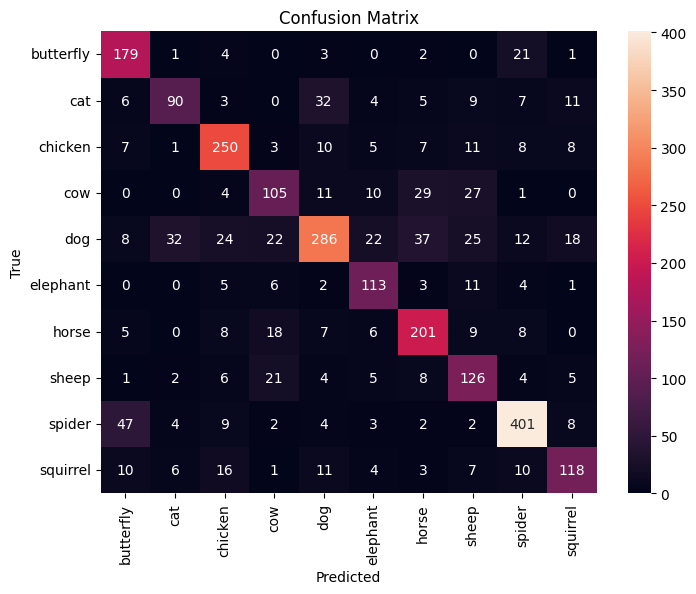

In [ ]:
# this model needs 10 more epochs to reach 80

conv5invto128_dense1 = keras.models.load_model(MODEL_PATH + 'conv5invto128_dense1.keras')
lr = 0.0005
PATIENCE = 10
EPOCHS = 10
conv5invto128_dense1_report = train_and_report(conv5invto128_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv5invto128_dense1_80total',lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE)

Not a marked improvement (actually a slight drop in test accuracy) with 10 more epochs of training. So this model may have reached its potential (on these settings at least).

Let's retrain the second and third-performing models with a higher number of epochs for better comparison.


## conv4invto128_dense1, 80 epochs

Epoch 1/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.1783 - loss: 2.2053 - val_accuracy: 0.3365 - val_loss: 1.8292
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3144 - loss: 1.9058 - val_accuracy: 0.4288 - val_loss: 1.6234
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.3975 - loss: 1.6980 - val_accuracy: 0.4662 - val_loss: 1.5420
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4573 - loss: 1.5474 - val_accuracy: 0.5183 - val_loss: 1.3857
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.4836 - loss: 1.4554 - val_accuracy: 0.5120 - val_loss: 1.3804
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5278 - loss: 1.3559 - val_accuracy: 0.5359 - val_loss: 1.3347
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.5459 - loss: 1.2954 - val_accuracy: 0.5817 - val_loss: 1.1969
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5683 - loss: 1.2255 - val_accu

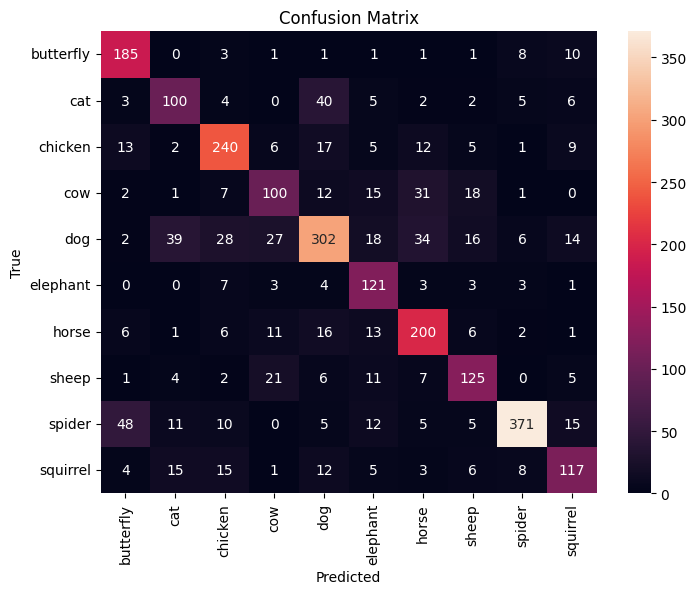

In [17]:
lr = 0.0005
EPOCHS = 80
PATIENCE=10

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4invto128_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4invto128_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4invto128_dense1_report = train_and_report(conv4invto128_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv4invto128_dense1',lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE)

Training stopped after 44 epochs (patience=10).
This result is very close to the model with 5 convolutional layers (conv5invto128_dense1) and for reasons of simplicity should be preferred. Time permitting, I might try tweaking aspects of the model architecture further, but for now, I'll save the model.

In [ ]:
# uncomment to save new
# conv4invto128_dense1.save(MODEL_PATH + 'conv4invto128_dense1.keras')

## conv4lesspoll (80 epochs)

Epoch 1/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.1569 - loss: 2.2232 - val_accuracy: 0.3205 - val_loss: 1.8399
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3113 - loss: 1.8890 - val_accuracy: 0.3734 - val_loss: 1.7425
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3957 - loss: 1.7116 - val_accuracy: 0.4456 - val_loss: 1.5443
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4487 - loss: 1.5660 - val_accuracy: 0.4943 - val_loss: 1.4396
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.4745 - loss: 1.5079 - val_accuracy: 0.4492 - val_loss: 1.5602
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5211 - loss: 1.3756 - val_accuracy: 0.5086 - val_loss: 1.4024
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5325 - loss: 1.3286 - val_accuracy: 0.5640 - val_loss: 1.2445
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5651 - loss: 1.2528 - 

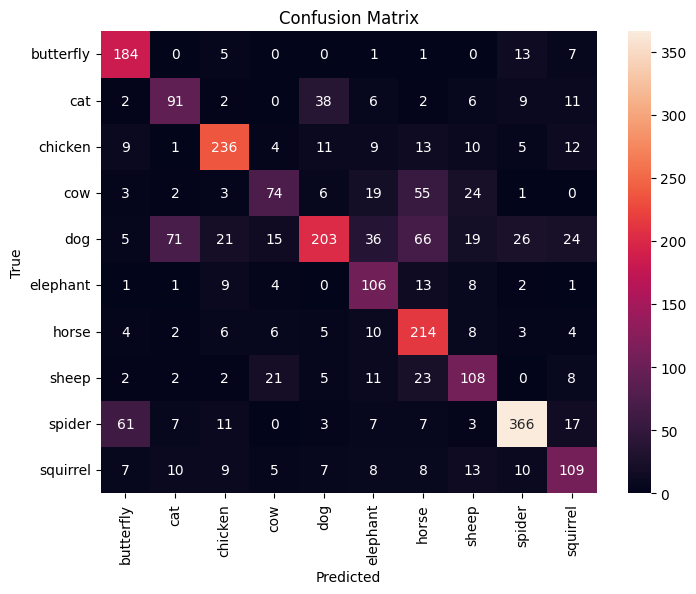

In [18]:
lr = 0.0005
EPOCHS = 80
PATIENCE=10

# Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(activity_regularizer=activity_regularizer, **kwargs)

specialAdam = keras.optimizers.Adam(learning_rate=lr)


conv4lesspoll_dense1 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(128, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4lesspoll_dense1.compile(optimizer=specialAdam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4lesspoll_dense1_report = train_and_report(conv4lesspoll_dense1,ds_midsample_train,ds_val,ds_test,test_df,'conv4lesspoll_dense1',lr,EPOCHS,BATCH_SIZE)

Training stopped after 23 epochs, test accuracy is markedly worse than the other two main candidates, so we can let go of this one.

In [19]:
del(conv4lesspoll_dense1)
gc.collect()

17575

# Last shots at a tweaked model

Building a variation on conv4invto128_dense1, which was already performing quite decently, but has some overfitting. 

## conv4inv128_pool_dense256

In [12]:
lr = 0.0001
EPOCHS = 80
PATIENCE=12


conv4inv128_pool_dense256 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(256, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4inv128_pool_dense256.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4inv128_pool_dense256.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,705,898 (6.51 MB)

 Trainable params: 1,705,898 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


I0000 00:00:1749823591.817205  771577 service.cc:146] XLA service 0xd44f8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749823591.817237  771577 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-13 16:06:31.836232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-13 16:06:31.982745: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 24/573 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0772 - loss: 2.3122

I0000 00:00:1749823594.647590  771577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1591 - loss: 2.2347

2025-06-13 16:06:40.736465: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_104', 8 bytes spill stores, 8 bytes spill loads

2025-06-13 16:06:42.581500: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_104', 12 bytes spill stores, 12 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.1591 - loss: 2.2345 - val_accuracy: 0.3027 - val_loss: 1.9181
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2965 - loss: 1.9571 - val_accuracy: 0.3409 - val_loss: 1.8658
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3408 - loss: 1.8371 - val_accuracy: 0.4099 - val_loss: 1.7107
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.3933 - loss: 1.7179 - val_accuracy: 0.3743 - val_loss: 1.8076
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4192 - loss: 1.6466 - val_accuracy: 0.4244 - val_loss: 1.6400
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4404 - loss: 1.5747 - val_accuracy: 0.4509 - val_loss: 1.5593
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4650 - loss: 1.5187 - val_accuracy: 0.4345 - val_loss: 1.6537
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.4914 - loss: 1.4603 - val_accuracy: 0.4920 - va

2025-06-13 16:14:00.992074: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Accuracy: 0.6390
Precision: 0.6644
Recall: 0.6390
F1 Score: 0.6366
              precision    recall  f1-score   support

   butterfly       0.80      0.79      0.79       211
         cat       0.43      0.49      0.46       167
     chicken       0.64      0.77      0.70       310
         cow       0.66      0.41      0.51       187
         dog       0.72      0.41      0.52       486
    elephant       0.44      0.77      0.56       145
       horse       0.69      0.69      0.69       262
       sheep       0.53      0.72      0.61       182
      spider       0.81      0.76      0.79       482
    squirrel       0.49      0.65      0.56       186

    accuracy                           0.64      2618
   macro avg       0.62      0.65      0.62      2618
weighted avg       0.66      0.64      0.64      2618



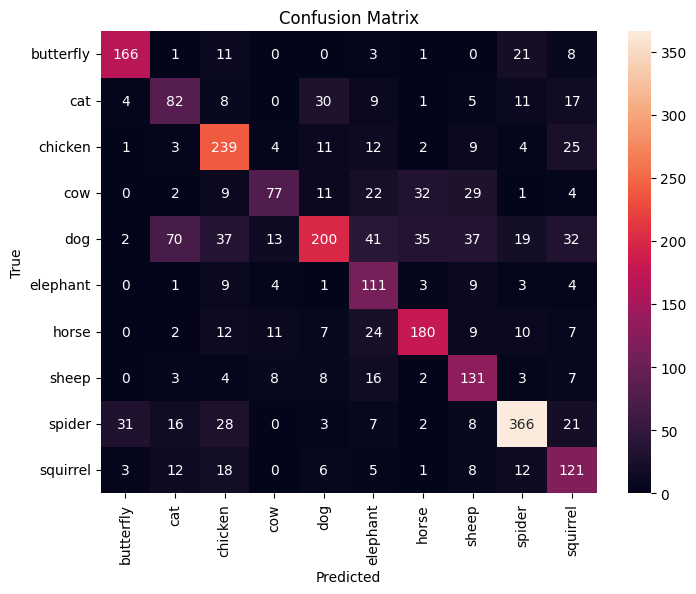

In [13]:
conv4inv128_pool_dense256_hist, conv4inv128_pool_dense256_report = train_and_report(conv4inv128_pool_dense256,
                                               ds_midsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv4inv128_pool_dense256',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

Not so great, well under .7 and quite some overfitting.

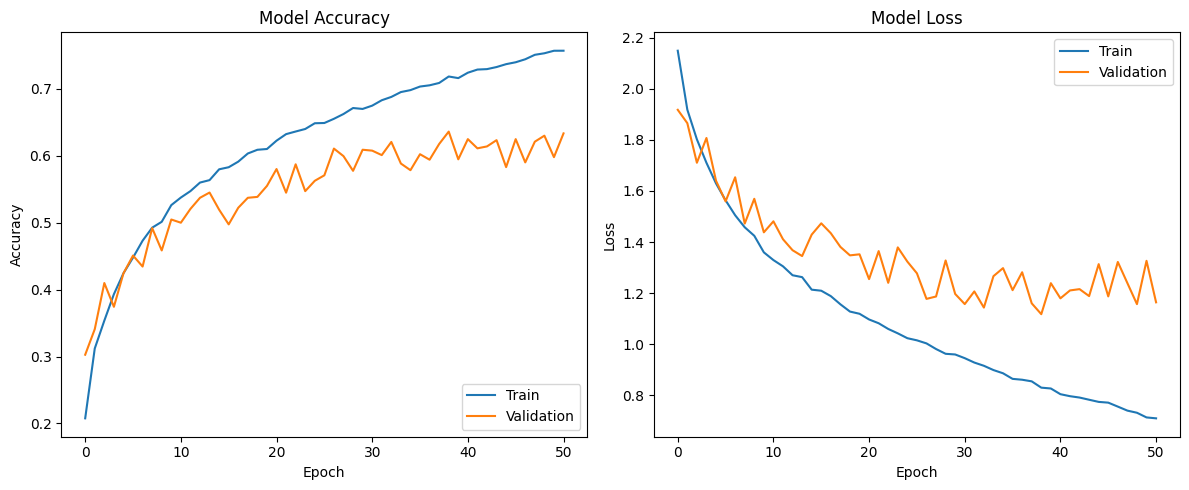

In [14]:
plothist(conv4inv128_pool_dense256_hist)

In [16]:
del(conv4inv128_pool_dense256)
gc.collect()
K.clear_session()

## conv4inv8to128_pool_dense196

In [17]:
lr = 0.0001
EPOCHS = 80
PATIENCE=12


conv4inv8to128_pool_dense196 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(8, (3,3), activation='relu'),
    MaxPooling2D(3,3),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(196, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4inv8to128_pool_dense196.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4inv8to128_pool_dense196.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 196)            │     1,229,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,326,390 (5.06 MB)

 Trainable params: 1,326,390 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.1554 - loss: 2.2437 - val_accuracy: 0.2655 - val_loss: 2.0157
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2585 - loss: 2.0522 - val_accuracy: 0.2806 - val_loss: 1.9403
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.2903 - loss: 1.9511 - val_accuracy: 0.3575 - val_loss: 1.8064
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3404 - loss: 1.8495 - val_accuracy: 0.3545 - val_loss: 1.8364
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.3742 - loss: 1.7584 - val_accuracy: 0.4015 - val_loss: 1.6959
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4051 - loss: 1.6829 - val_accuracy: 0.4654 - val_loss: 1.5469
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4302 - loss: 1.6239 - val_accuracy: 0.4557 - val_loss: 1.5897
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4540 - loss: 1.5712 - val_accuracy: 

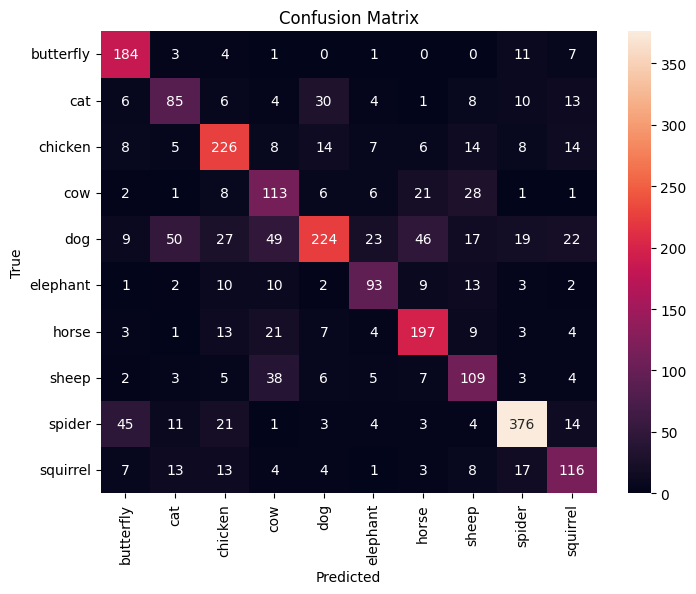

In [18]:
conv4inv8to128_pool_dense196_hist, conv4inv8to128_pool_dense196_report = train_and_report(conv4inv8to128_pool_dense196,
                                               ds_midsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv4inv8to128_pool_dense196',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

Again, decent, but not worth the effort.

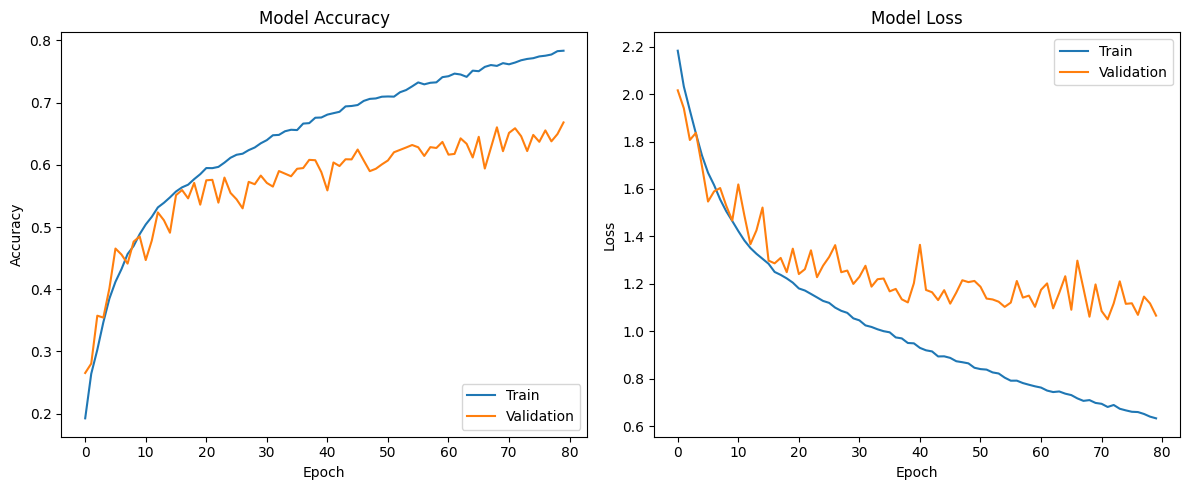

In [19]:
plothist(conv4inv8to128_pool_dense196_hist,export='assets/conv4inv8to128_pool_dense196.png')

In [20]:
del(conv4inv8to128_pool_dense196)
gc.collect()
K.clear_session()

In [21]:
lr = 0.0001
EPOCHS = 80
PATIENCE=12


conv4inv8to128_dense96 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(8, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(96, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4inv8to128_dense96.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4inv8to128_dense96.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │     1,769,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,865,450 (7.12 MB)

 Trainable params: 1,865,450 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - accuracy: 0.1618 - loss: 2.2351 - val_accuracy: 0.2651 - val_loss: 1.9881
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2653 - loss: 2.0363 - val_accuracy: 0.2985 - val_loss: 1.9119
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3041 - loss: 1.9367 - val_accuracy: 0.3612 - val_loss: 1.7650
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.3321 - loss: 1.8670 - val_accuracy: 0.3552 - val_loss: 1.8063
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3563 - loss: 1.7944 - val_accuracy: 0.3825 - val_loss: 1.7370
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3761 - loss: 1.7370 - val_accuracy: 0.3927 - val_loss: 1.7198
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4006 - loss: 1.6935 - val_accuracy: 0.4545 - val_loss: 1.5595
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.4199 - loss: 1.6541 - 

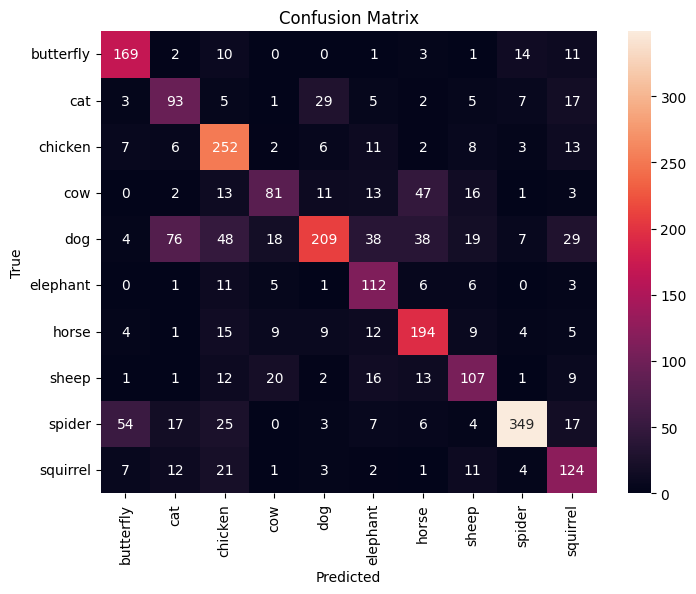

In [22]:
conv4inv8to128_dense96_hist, conv4inv8to128_dense96_report = train_and_report(conv4inv8to128_dense96,
                                               ds_midsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv4inv8to128_dense96',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

## conv4inv128_dense1: upsampled training

In [ ]:
lr = 0.0005
EPOCHS = 80
PATIENCE = 10


conv4invto128_dense256 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(256, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4invto128_dense256.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4invto128_dense256.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,818,858 (18.38 MB)

 Trainable params: 4,818,858 (18.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


I0000 00:00:1749853050.930872    4448 service.cc:146] XLA service 0x7f29c00071a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749853050.930901    4448 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-14 00:17:30.950009: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-14 00:17:31.104072: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 17/573 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.0971 - loss: 2.3334

I0000 00:00:1749853054.982715    4448 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.1696 - loss: 2.2177 - val_accuracy: 0.3044 - val_loss: 1.9645
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3319 - loss: 1.8663 - val_accuracy: 0.4406 - val_loss: 1.5519
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4216 - loss: 1.6209 - val_accuracy: 0.4727 - val_loss: 1.4963
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4939 - loss: 1.4545 - val_accuracy: 0.5476 - val_loss: 1.3031
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5394 - loss: 1.3305 - val_accuracy: 0.5344 - val_loss: 1.3542
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5643 - loss: 1.2354 - val_accuracy: 0.5726 - val_loss: 1.2481
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.6101 - loss: 1.1390 - val_accuracy: 0.6178 - val_loss: 1.1250
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6325 - loss: 1.0664 - val_accurac

2025-06-14 00:23:14.460997: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Accuracy: 0.7028
Precision: 0.7185
Recall: 0.7028
F1 Score: 0.7039
              precision    recall  f1-score   support

   butterfly       0.73      0.82      0.78       211
         cat       0.51      0.59      0.55       167
     chicken       0.74      0.84      0.79       310
         cow       0.59      0.62      0.61       187
         dog       0.78      0.54      0.64       486
    elephant       0.63      0.68      0.66       145
       horse       0.68      0.75      0.72       262
       sheep       0.55      0.73      0.62       182
      spider       0.91      0.79      0.85       482
    squirrel       0.61      0.64      0.63       186

    accuracy                           0.70      2618
   macro avg       0.67      0.70      0.68      2618
weighted avg       0.72      0.70      0.70      2618



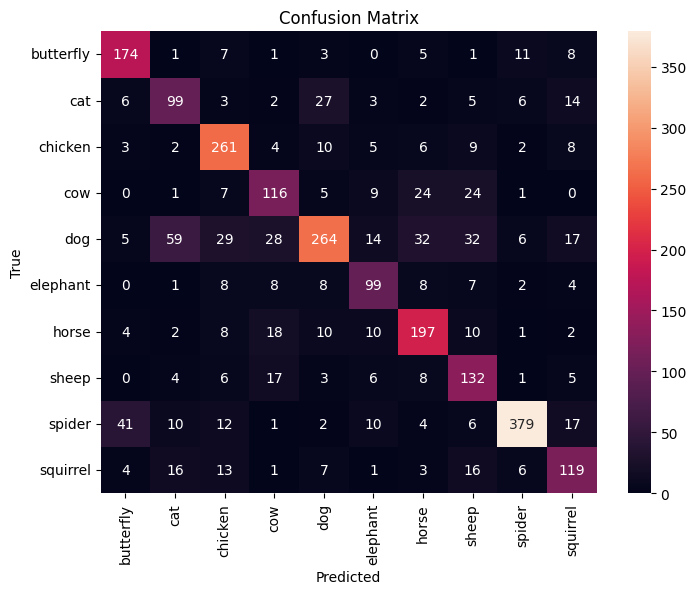

In [13]:
conv4invto128_dense256_hist, conv4invto128_dense256_report = train_and_report(conv4invto128_dense256,
                                               ds_midsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv4invto128_dense256',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

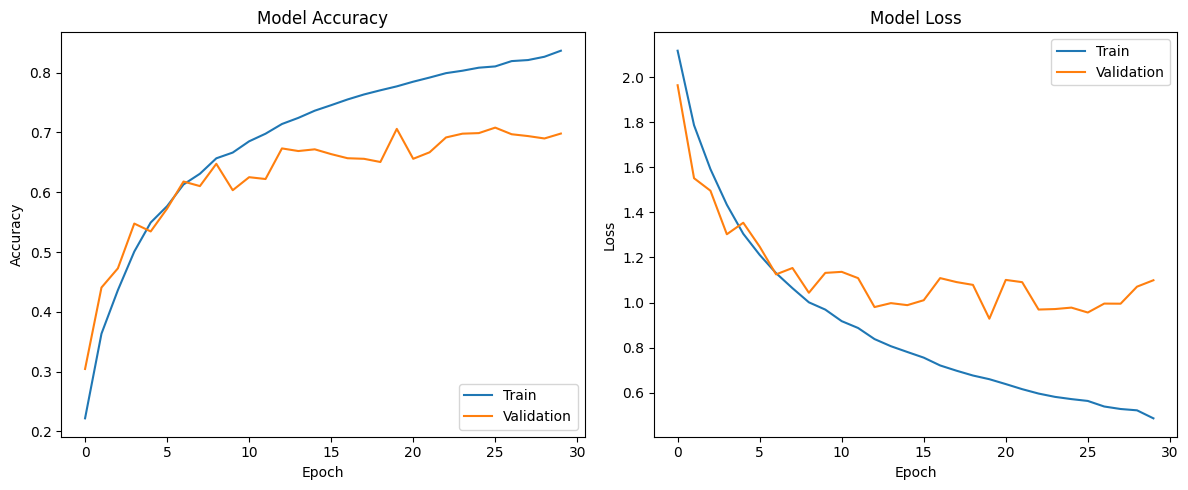

In [15]:
plothist(conv4invto128_dense256_hist,export='assets/conv4invto128_dense256.png')

conv4invto128_dense256.save(MODEL_PATH + 'conv4invto128_dense256.keras')

In [16]:
K.clear_session()

## conv4invto128_dense256_upsamp

In [15]:
lr = 0.0005
EPOCHS = 80
PATIENCE = 10


conv4invto128_dense256_upsamp = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(256, activation='relu'),
    Dropout(0.35),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv4invto128_dense256_upsamp.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv4invto128_dense256_upsamp.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,818,858 (18.38 MB)

 Trainable params: 4,818,858 (18.38 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.2386 - loss: 2.0737 - val_accuracy: 0.3846 - val_loss: 1.7191
Epoch 2/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4290 - loss: 1.6134 - val_accuracy: 0.4576 - val_loss: 1.5591
Epoch 3/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5123 - loss: 1.4012 - val_accuracy: 0.5262 - val_loss: 1.3420
Epoch 4/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5737 - loss: 1.2271 - val_accuracy: 0.5523 - val_loss: 1.2936
Epoch 5/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6184 - loss: 1.1131 - val_accuracy: 0.5827 - val_loss: 1.2052
Epoch 6/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6446 - loss: 1.0272 - val_accuracy: 0.5686 - val_loss: 1.2760
Epoch 7/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6771 - loss: 0.9381 - val_accuracy: 0.6490 - val_loss: 1.0622
Epoch 8/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6952 -

2025-06-14 00:51:17.202618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 33500 of 34040
2025-06-14 00:51:17.366786: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.7969 - loss: 0.5983 - val_accuracy: 0.6950 - val_loss: 1.0121
Epoch 16/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.8042 - loss: 0.5716 - val_accuracy: 0.7040 - val_loss: 0.9525
Epoch 17/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.8137 - loss: 0.5531 - val_accuracy: 0.6858 - val_loss: 1.0603
Epoch 18/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8155 - loss: 0.5438 - val_accuracy: 0.7023 - val_loss: 0.9553
Epoch 19/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8280 - loss: 0.5185 - val_accuracy: 0.7047 - val_loss: 1.0179
Epoch 20/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8294 - loss: 0.5075 - val_accuracy: 0.6811 - val_loss: 1.1129
Epoch 21/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8346 - loss: 0.4900 - val_accuracy: 0.7215 - val_loss: 0.9533
Epoch 22/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8406 - los

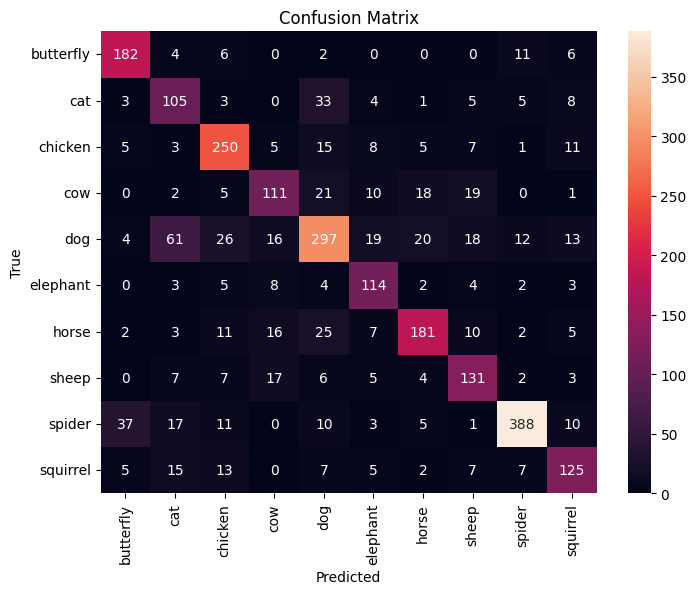

In [16]:
conv4invto128_pense256_upsamp_hist, conv4invto128_dense256_upsamp_report = train_and_report(conv4invto128_dense256_upsamp,
                                               ds_upsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv4invto128_dense256_upsamp',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

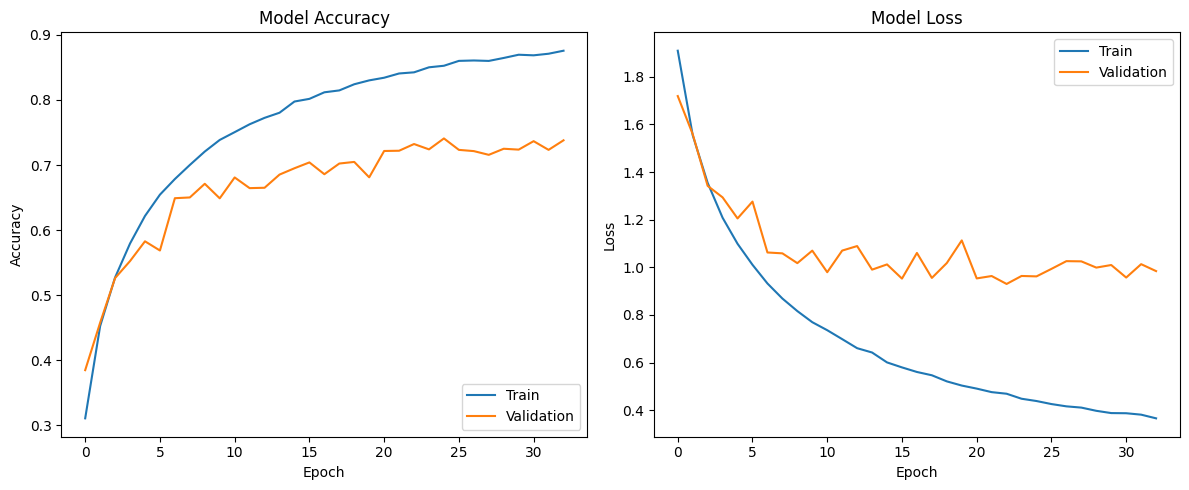

In [ ]:
plothist(conv4invto128_pense256_upsamp_hist,export="assets/conv4invto128_dense256_upsamp.png")

#conv4invto128_dense256_upsamp.save(MODEL_PATH + 'conv4invto128_dense256_upsamp.keras')

In [ ]:
def m2tex(model,modelName):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: {} \\\\ \hline".format(modelName)
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] += " \hline"
    stringlist[-3] += " \\\\"
    stringlist[-2] += " \\\\"
    stringlist[-1] += " \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{{Model summary for {}.}}".format(modelName), "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

## conv5invto128_dense256

In [14]:
lr = 0.0002
EPOCHS = 80
PATIENCE = 13


conv5invto128_dense256 = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(8, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(256, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv5invto128_dense256.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv5invto128_dense256.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 920,410 (3.51 MB)

 Trainable params: 920,410 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


I0000 00:00:1749988920.531187   44108 service.cc:146] XLA service 0x7f1680020ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749988920.531220   44108 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-15 14:02:00.550847: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-15 14:02:00.698969: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101


 24/573 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.1220 - loss: 2.3033

I0000 00:00:1749988923.405490   44108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1603 - loss: 2.2251

2025-06-15 14:02:09.431856: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_120', 8 bytes spill stores, 8 bytes spill loads

2025-06-15 14:02:11.209496: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_120', 12 bytes spill stores, 12 bytes spill loads



573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.1604 - loss: 2.2250 - val_accuracy: 0.2706 - val_loss: 1.9510
Epoch 2/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2778 - loss: 1.9783 - val_accuracy: 0.3107 - val_loss: 1.8616
Epoch 3/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.3490 - loss: 1.8156 - val_accuracy: 0.3741 - val_loss: 1.7463
Epoch 4/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4050 - loss: 1.6776 - val_accuracy: 0.4301 - val_loss: 1.5804
Epoch 5/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4322 - loss: 1.6023 - val_accuracy: 0.4429 - val_loss: 1.5724
Epoch 6/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4726 - loss: 1.4965 - val_accuracy: 0.4935 - val_loss: 1.4452
Epoch 7/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4903 - loss: 1.4422 - val_accuracy: 0.5275 - val_loss: 1.3740
Epoch 8/80
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.5196 - loss: 1.3644 - val_accuracy: 0.5460 - v

2025-06-15 14:09:55.266314: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Accuracy: 0.6707
Precision: 0.6919
Recall: 0.6707
F1 Score: 0.6707
              precision    recall  f1-score   support

   butterfly       0.68      0.86      0.76       211
         cat       0.53      0.63      0.58       167
     chicken       0.69      0.75      0.72       310
         cow       0.54      0.53      0.54       187
         dog       0.74      0.49      0.59       486
    elephant       0.49      0.83      0.61       145
       horse       0.65      0.74      0.69       262
       sheep       0.68      0.59      0.63       182
      spider       0.90      0.74      0.81       482
    squirrel       0.57      0.65      0.61       186

    accuracy                           0.67      2618
   macro avg       0.65      0.68      0.65      2618
weighted avg       0.69      0.67      0.67      2618



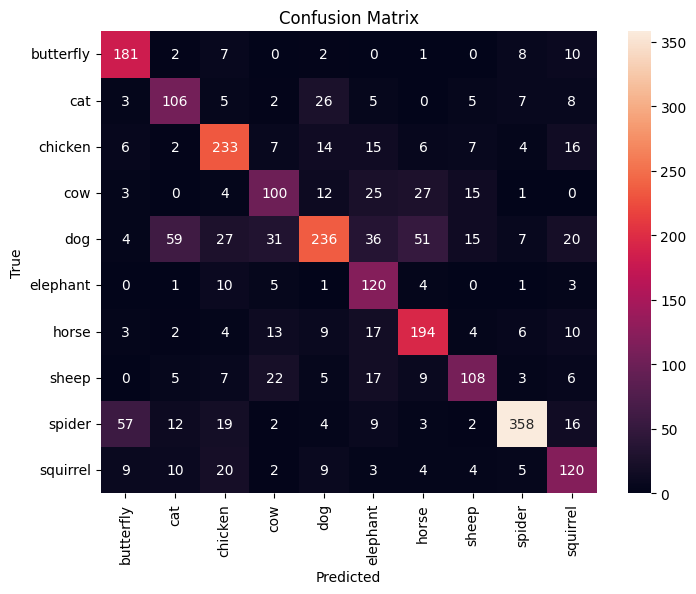

In [15]:
conv5invto128_dense256_hist, conv5invto128_dense256_report = train_and_report(conv5invto128_dense256,
                                               ds_midsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv5invto128_dense256',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

In [ ]:
# plothist(conv5invto128_dense256_hist,export="assets/conv5invto128_dense256.png")

# conv5invto128_dense256.save(MODEL_PATH + 'conv5invto128_dense256.keras')

Results don't exceed previous ones, no need to save.

In [16]:
K.clear_session()

## conv5invto128_dense256_uspamp

In [17]:
lr = 0.0002
EPOCHS = 80
PATIENCE = 13


conv5invto128_dense256_upsamp = Sequential([
    Input(shape=(IMG_SIZE,IMG_SIZE,3)),
    Conv2D(8, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(16, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    # Flatten the 2D feature maps into a 1D vector for dense layers
    Flatten(),
    # Fully connected (dense) layer with 128 neurons and ReLU activation
    #Learns intermediate features from the previous layers
    Dense(256, activation='relu'),
    Dropout(0.3),
    # Output layer with 10 neurons (for 10 classes) and softmax activation
    #Produces the final probabilities for each class.
    Dense(10, activation='softmax')
])
conv5invto128_dense256_upsamp.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

conv5invto128_dense256_upsamp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 920,410 (3.51 MB)

 Trainable params: 920,410 (3.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80


2025-06-15 14:17:14.685970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:7: Filling up shuffle buffer (this may take a while): 29553 of 34040
2025-06-15 14:17:17.278959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1064/1064 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.2057 - loss: 2.1525 - val_accuracy: 0.4064 - val_loss: 1.6687
Epoch 2/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3959 - loss: 1.7064 - val_accuracy: 0.4628 - val_loss: 1.5512
Epoch 3/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4765 - loss: 1.4983 - val_accuracy: 0.4834 - val_loss: 1.4410
Epoch 4/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5194 - loss: 1.3709 - val_accuracy: 0.5550 - val_loss: 1.2732
Epoch 5/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5579 - loss: 1.2705 - val_accuracy: 0.5720 - val_loss: 1.2183
Epoch 6/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5875 - loss: 1.1876 - val_accuracy: 0.5968 - val_loss: 1.1608
Epoch 7/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6085 - loss: 1.1240 - val_accuracy: 0.6022 - val_loss: 1.1327
Epoch 8/80
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.6316 - loss: 1.0797 - va

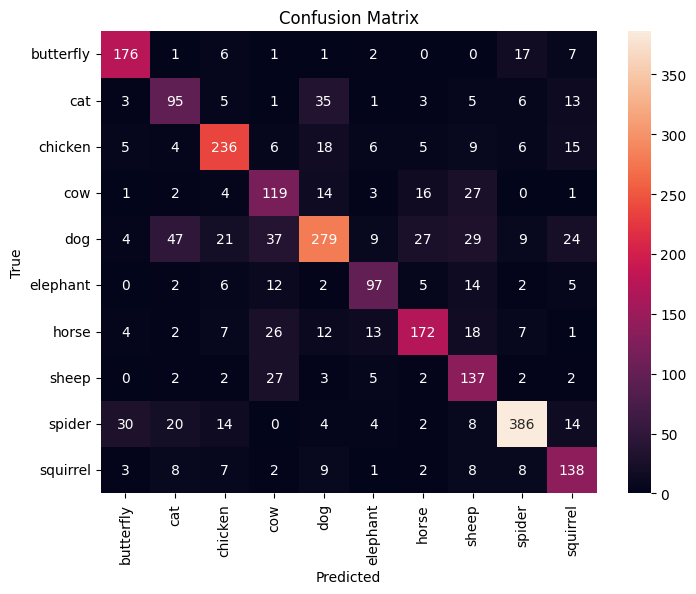

In [18]:
conv5invto128_dense256_upsamp_hist, conv5invto128_dense256_upsamp_report = train_and_report(conv5invto128_dense256_upsamp,
                                               ds_upsample_train,
                                               ds_val,
                                               ds_test,
                                               test_df,
                                               'conv5invto128_dense256_upsamp',
                                               lr,EPOCHS,BATCH_SIZE,early_patience=PATIENCE,returnhist=True)

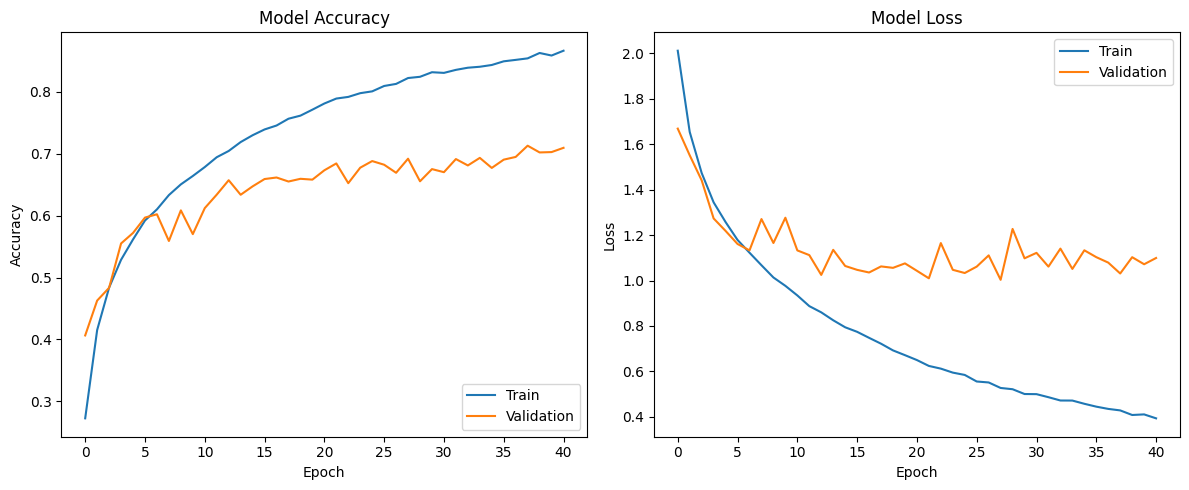

In [ ]:
plothist(conv5invto128_dense256_upsamp_hist,export="assets/conv5invto128_dense256_upsamp.png")

# conv5invto128_dense256_upsamp.save(MODEL_PATH + 'conv5invto128_dense256_upsamp.keras')